<a href="https://colab.research.google.com/github/Habiba3495/gp-depi/blob/main/stock_analysis_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("camnugent/sandp500")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sandp500' dataset.
Path to dataset files: /kaggle/input/sandp500


In [ ]:
# Assuming the data is in a CSV file within the downloaded path
# You might need to adjust the filename if it's different
csv_file_path = path + '/all_stocks_5yr.csv'  # Adjust filename if needed
df = pd.read_csv(csv_file_path)
display(df.head())

date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [ ]:
import os

# List files in the downloaded directory to find the correct CSV file path
downloaded_files = os.listdir(path)
print("Files in downloaded directory:", downloaded_files)

Files in downloaded directory: ['merge.sh', 'getSandP.py', 'individual_stocks_5yr', 'all_stocks_5yr.csv']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [ ]:
print(df.isnull().sum())

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


In [ ]:
df_clean = df.dropna()

In [ ]:
print(df_clean.isnull().sum())

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


In [ ]:
df_clean.duplicated().sum()

np.int64(0)

In [ ]:
df_clean.describe()

date           open           high  \
count                      619029  619029.000000  619029.000000   
mean   2015-08-18 00:45:31.033280      83.023334      83.778419   
min           2013-02-08 00:00:00       1.620000       1.690000   
25%           2014-05-20 00:00:00      40.220000      40.620000   
50%           2015-08-21 00:00:00      62.590000      63.150000   
75%           2016-11-15 00:00:00      94.370000      95.180000   
max           2018-02-07 00:00:00    2044.000000    2067.990000   
std                           NaN      97.378769      98.207735   

                 low          close        volume  
count  619029.000000  619029.000000  6.190290e+05  
mean       82.256200      83.043305  4.321892e+06  
min         1.500000       1.590000  1.010000e+02  
25%        39.830000      40.240800  1.070351e+06  
50%        62.020000      62.620000  2.082165e+06  
75%        93.540000      94.410000  4.284550e+06  
max      2035.110000    2049.000000  6.182376e+08  
std        96.507634      97.388913  8.693671e+06

 ### Below: Represents the stock's risk profile, showing that small daily price changes are the norm, and extreme movements are rare.

/tmp/ipython-input-1269361659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['daily_return'] = df_clean['close'].pct_change()


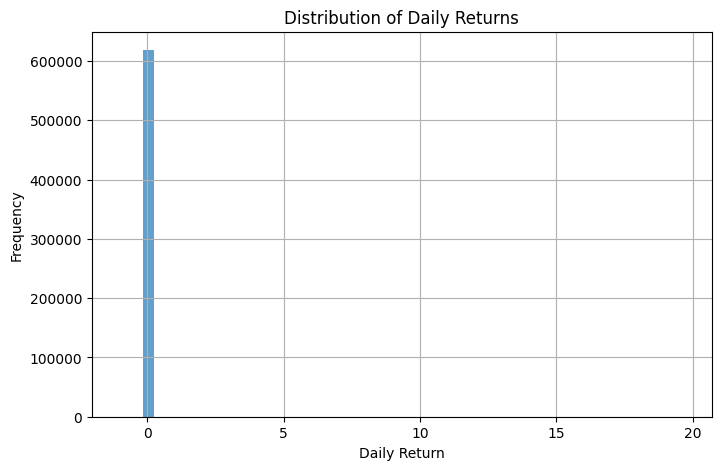

In [ ]:
#ASE
# Calculate and plot daily returns distribution
df_clean['daily_return'] = df_clean['close'].pct_change()

plt.figure(figsize=(8,5))
df_clean['daily_return'].hist(bins=50, alpha=0.7)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

In [ ]:
Q1 = df_clean["close"].quantile(0.25)
Q3 = df_clean["close"].quantile(0.75)
IQR = Q3 - Q1

outliers = df_clean[(df_clean["close"] < Q1 - 1.5*IQR) | (df_clean["close"] > Q3 + 1.5*IQR)]

In [ ]:
num_outliers = outliers.shape[0]
total_rows = df_clean.shape[0]

percentage = (num_outliers / total_rows) * 100

print(f"number of outliers: {num_outliers}")
print(f"percentage: {percentage:.2f}%")


number of outliers: 38930
percentage: 6.29%


In [ ]:
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

/tmp/ipython-input-1472045736.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
/tmp/ipython-input-1472045736.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
/tmp/ipython-input-1472045736.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
print(df_clean.describe())

                             date           open           high  \
count                      619029  619029.000000  619029.000000   
mean   2015-08-18 00:45:31.033280      73.001563      73.654279   
min           2013-02-08 00:00:00       1.620000       1.690000   
25%           2014-05-20 00:00:00      40.220000      40.620000   
50%           2015-08-21 00:00:00      62.590000      63.150000   
75%           2016-11-15 00:00:00      94.370000      95.180000   
max           2018-02-07 00:00:00     175.595000     177.020000   
std                           NaN      43.677789      44.024722   

                 low          close        volume   daily_return  
count  619029.000000  619029.000000  6.190290e+05  619028.000000  
mean       72.340742      73.023583  3.114589e+06       0.000573  
min         1.500000       1.590000  1.010000e+02      -0.029182  
25%        39.830000      40.240800  1.070351e+06      -0.006809  
50%        62.020000      62.620000  2.082165e+06       0.000

In [ ]:
Q1 = df_clean["close"].quantile(0.25)
Q3 = df_clean["close"].quantile(0.75)
IQR = Q3 - Q1

outliers = df_clean[(df_clean["close"] < Q1 - 1.5*IQR) | (df_clean["close"] > Q3 + 1.5*IQR)]

In [ ]:
num_outliers = outliers.shape[0]
total_rows = df_clean.shape[0]

percentage = (num_outliers / total_rows) * 100

print(f"number of outliers: {num_outliers}")
print(f"percentage: {percentage:.2f}%")

number of outliers: 0
percentage: 0.00%


In [ ]:
df_clean.head()

date   open   high    low  close     volume Name  daily_return
0 2013-02-08  15.07  15.12  14.63  14.75  8407500.0  AAL           NaN
1 2013-02-11  14.89  15.01  14.26  14.46  8882000.0  AAL     -0.019661
2 2013-02-12  14.45  14.51  14.10  14.27  8126000.0  AAL     -0.013140
3 2013-02-13  14.30  14.94  14.25  14.66  9105848.5  AAL      0.027330
4 2013-02-14  14.94  14.96  13.16  13.99  9105848.5  AAL     -0.029182

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

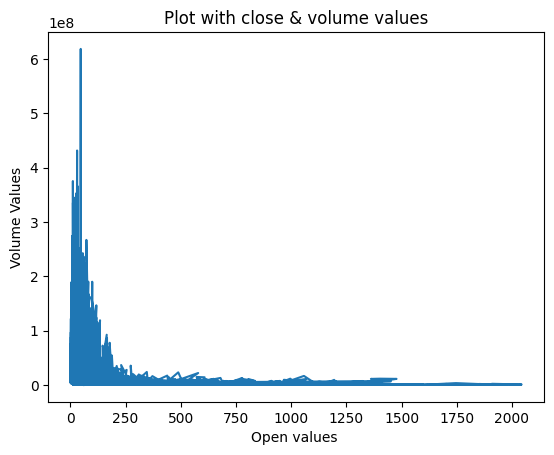

In [ ]:
plt.plot(df['open'],df['volume'] )
plt.title('Plot with close & volume values')
plt.xlabel("Open values ")
plt.ylabel("Volume Values")
plt.show()

### The plot above shows an extreme concentration of high volume at low Open Price values (below 250), with volume dropping sharply for higher prices, indicating an inverse correlation.



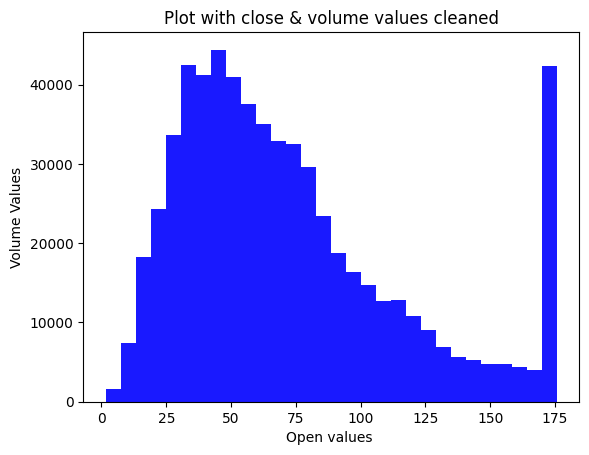

In [ ]:
plt.hist(df_clean["open"],bins=30,alpha=0.9 ,color="blue")
plt.title('Plot with close & volume values cleaned')
plt.xlabel("Open values ")
plt.ylabel("Volume Values")
plt.show()

### After likely removing high-price outliers, the plot reveals a persistent high volume across all lower price values (0 to 175), suggesting a cleaning process was applied.



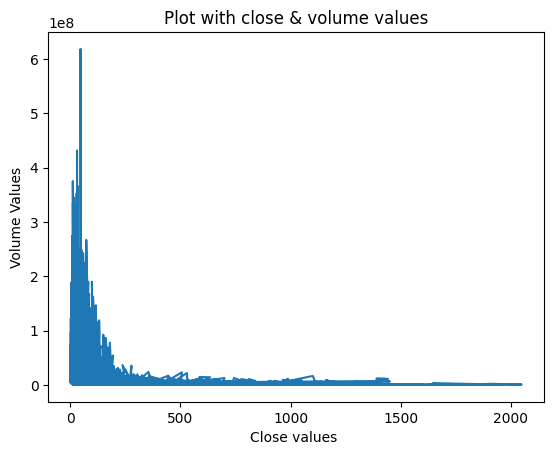

In [ ]:
plt.plot(df['close'],df['volume'] )
plt.title('Plot with close & volume values')
plt.xlabel("Close values ")
plt.ylabel("Volume Values")
plt.show()

### Similar to the Open price, the majority of trading volume is heavily concentrated at low Close Price values (below 250), confirming that high volume activity occurs when the stock price is low.



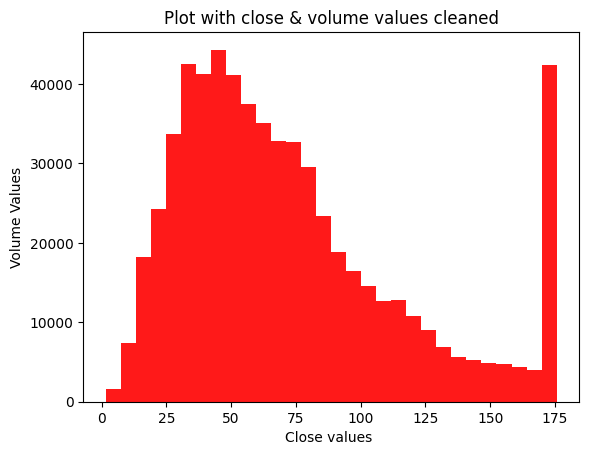

In [ ]:
plt.hist(df_clean['close'],bins=30,alpha=0.9 ,color="red")
plt.title('Plot with close & volume values cleaned')
plt.xlabel("Close values ")
plt.ylabel("Volume Values")
plt.show()

### After outlier removal, the plot shows uniformly high volume across all remaining low Close Price values (0 to 175), confirming high trading activity in this price range.

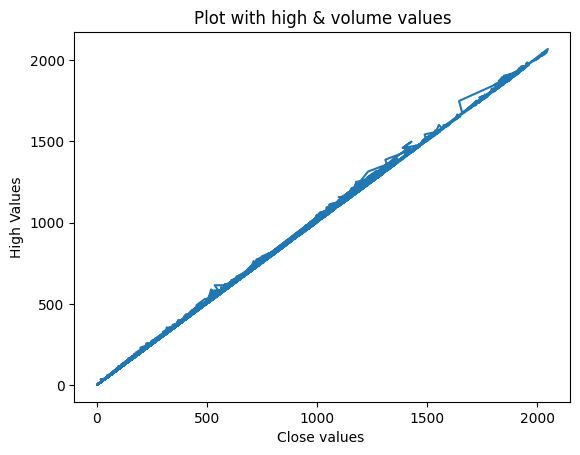

In [ ]:
plt.plot(df['close'],df['high'] )
plt.title('Plot with high & volume values')
plt.xlabel("Close values ")
plt.ylabel("High Values")
plt.show()

### The plot displays a perfectly linear, strong positive relationship between Close and High prices, with the relationship breaking down and showing outliers at extremely high price values.

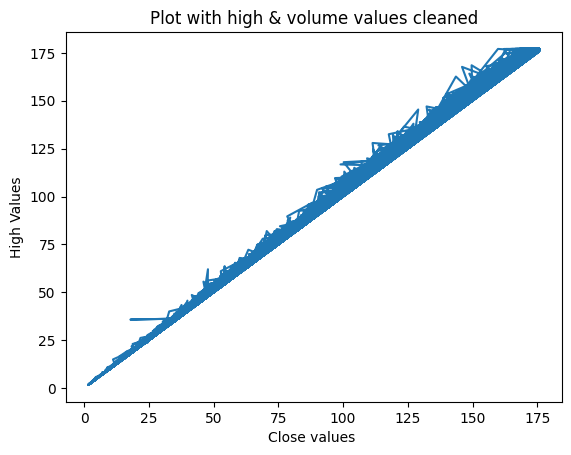

In [ ]:
plt.plot(df_clean['close'],df_clean['high'] )
plt.title('Plot with high & volume values cleaned')
plt.xlabel("Close values ")
plt.ylabel("High Values")
plt.show()

### The relationship remains strongly linear after outlier removal, confirming that the Close price is almost always identical or very close to the High price on any given day.

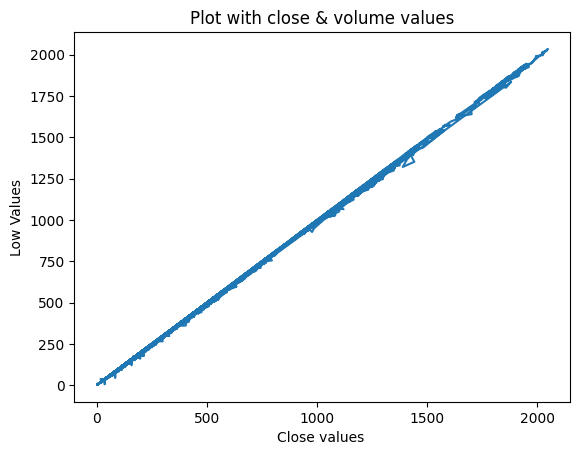

In [ ]:
plt.plot(df['close'],df['low'] )
plt.title('Plot with close & volume values')
plt.xlabel("Close values ")
plt.ylabel("Low Values")
plt.show()

### The plot shows a near-perfect linear correlation between the Close and Low prices, with the relationship breaking down due to outliers at very high price values.

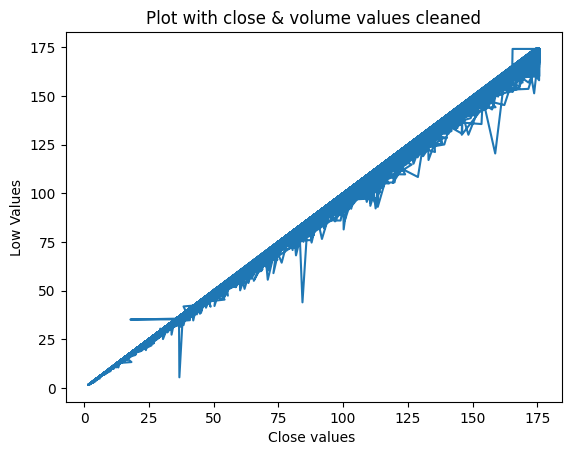

In [ ]:
plt.plot(df_clean['close'],df_clean['low'] )
plt.title('Plot with close & volume values cleaned')
plt.xlabel("Close values ")
plt.ylabel("Low Values")
plt.show()

### After outlier removal, the relationship remains strongly linear, confirming the Close price is almost always identical or very close to the Low price on a given day.

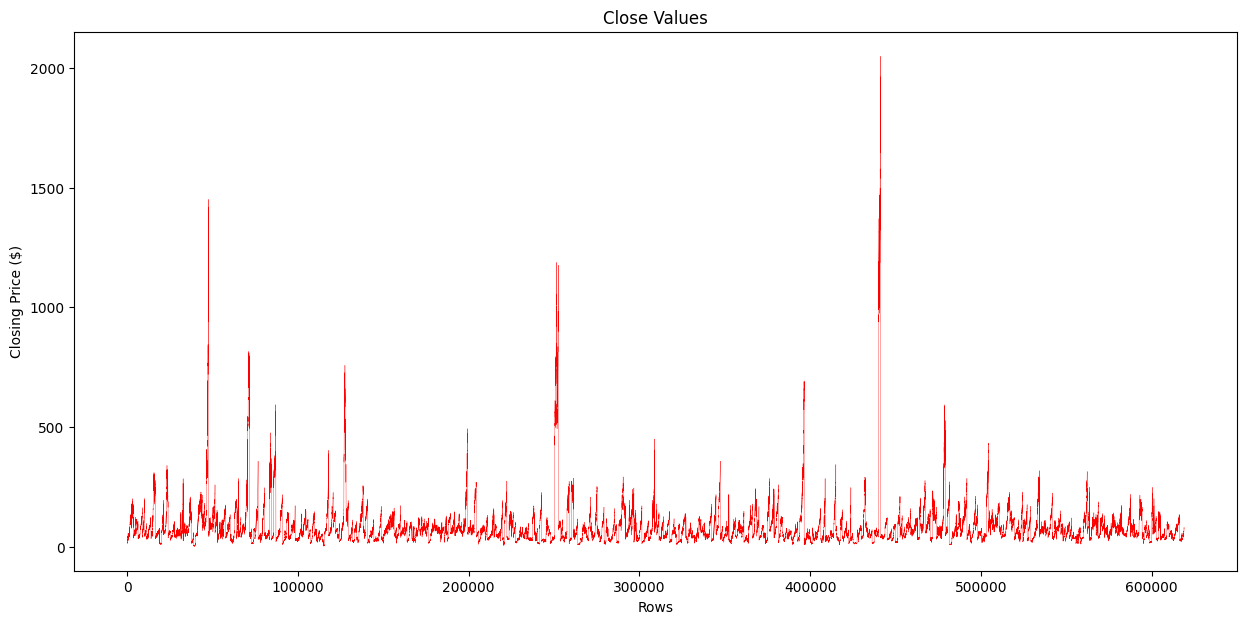

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot (df['close'] , color = 'red' ,linewidth=.25 )
plt.title('Close Values')
plt.xlabel('Rows')
plt.ylabel('Closing Price ($)')
plt.show()

### The time series plot reveals that the Close price is generally low and stable, punctuated by infrequent, extreme, high-magnitude spikes (outliers) across the observation period.

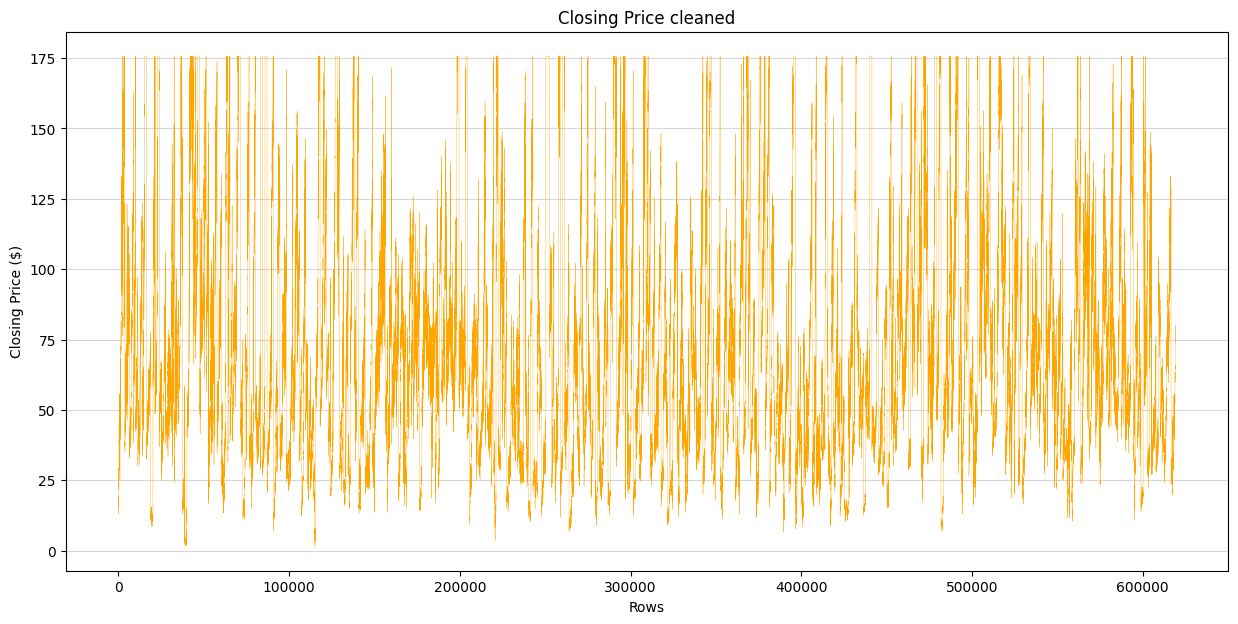

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot (df_clean['close'] , color = 'orange',  linewidth=.25)
plt.title('Closing Price cleaned')
plt.xlabel('Rows')
plt.ylabel('Closing Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The cleaned Closing Price shows high day-to-day volatility with values consistently fluctuating between approximately $25 and $175, with no clear long-term trend.

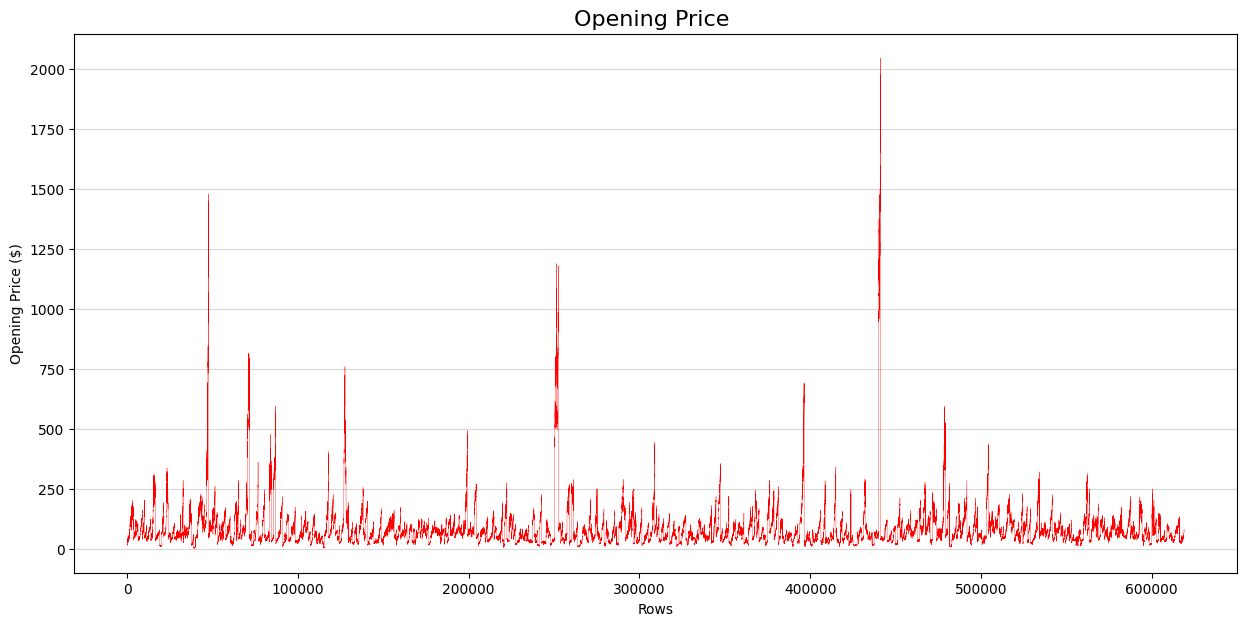

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['open'], color = 'red' , linewidth=.25)
plt.title('Opening Price ', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('Opening Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The Opening Price time series is highly volatile, characterized by frequent extreme spikes (outliers), reaching values well over $1,500, punctuated by periods of low, stable prices.

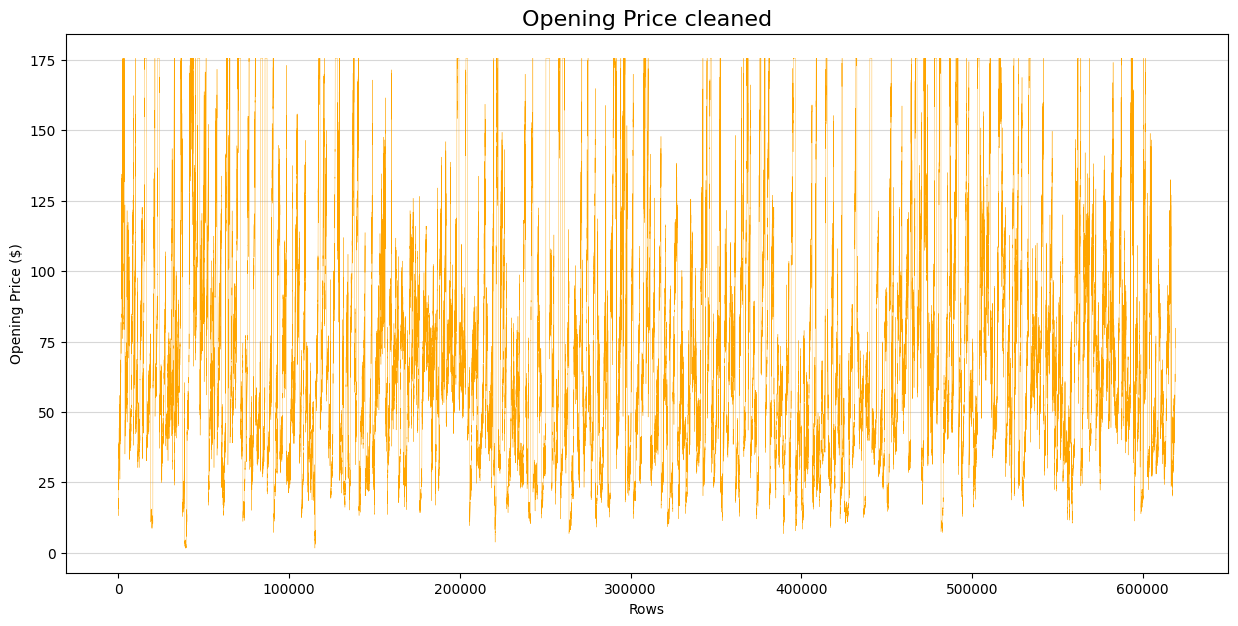

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean['open'],color ='orange', linewidth=.25)
plt.title('Opening Price cleaned', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('Opening Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The cleaned Opening Price shows high day-to-day volatility with prices consistently fluctuating between approximately $25 and $175, with no discernible long-term trend.

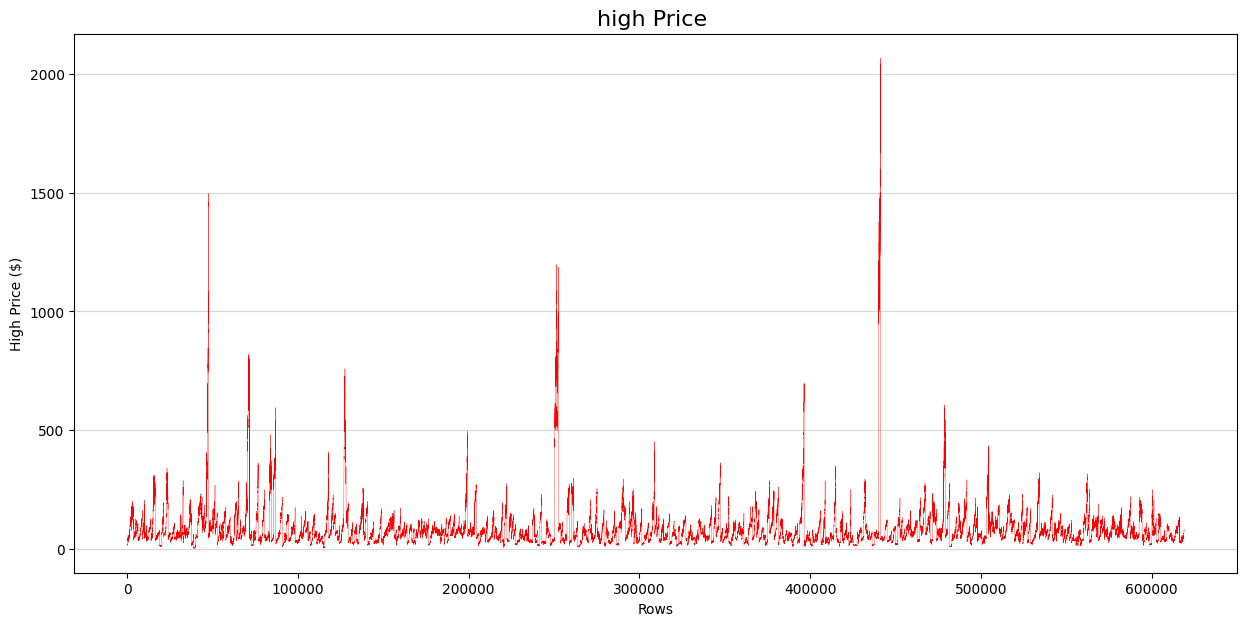

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['high'], color = 'red' , linewidth=.25)
plt.title('high Price ', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('High Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The High Price time series is highly volatile, characterized by frequent extreme spikes (outliers), reaching values well over $2,000, interspersed with prolonged periods of low, stable prices.

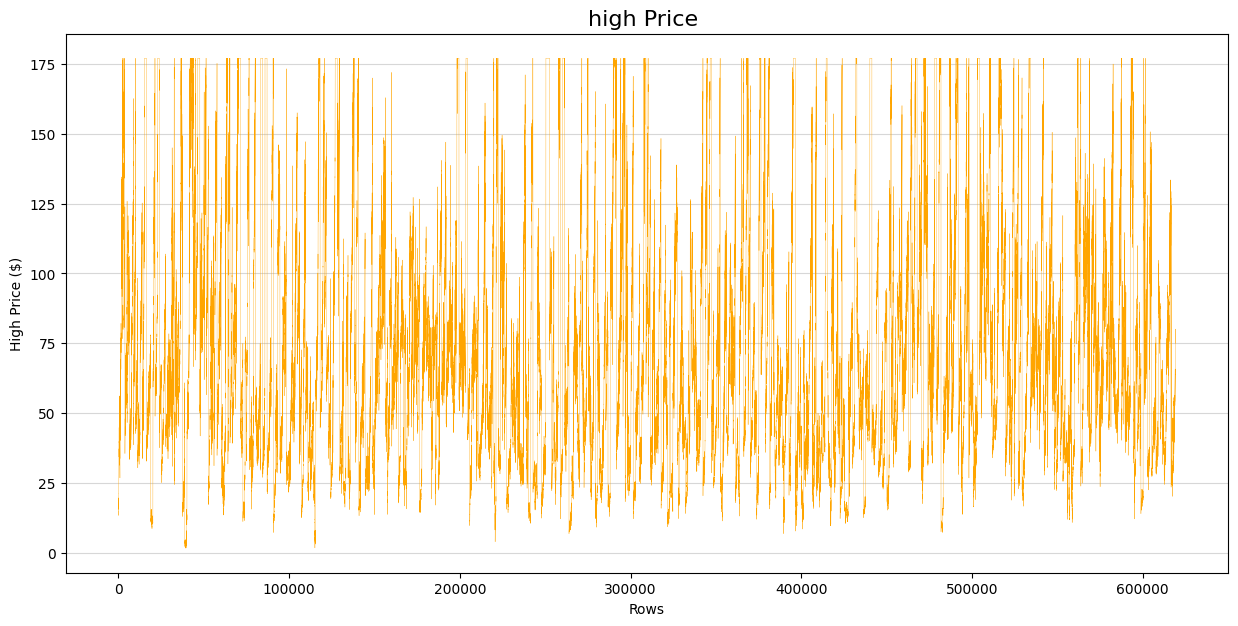

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean['high'],color ='orange', linewidth=.25)
plt.title('high Price ', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('High Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The cleaned High Price shows high day-to-day volatility with values consistently fluctuating between approximately $25 and $175, with no clear long-term trend.

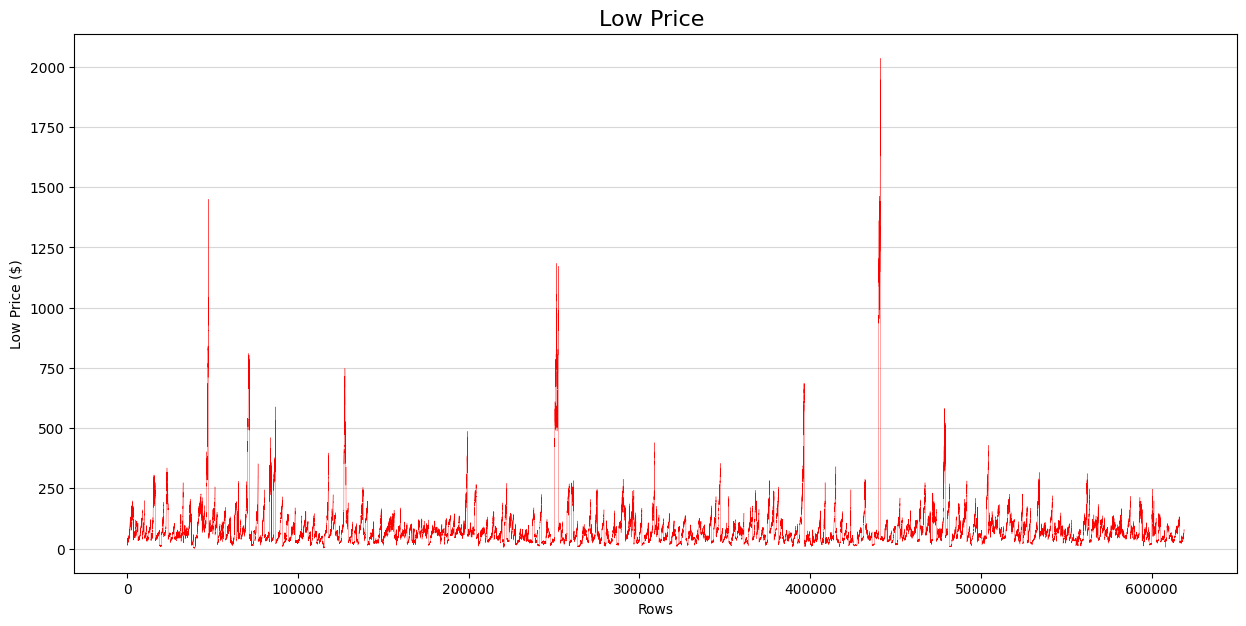

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['low'], color = 'red' , linewidth=.25)
plt.title('Low Price ', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('Low Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The Low Price time series is highly volatile, characterized by frequent extreme spikes (outliers), reaching values well over $1,500, interspersed with prolonged periods of low, stable prices.

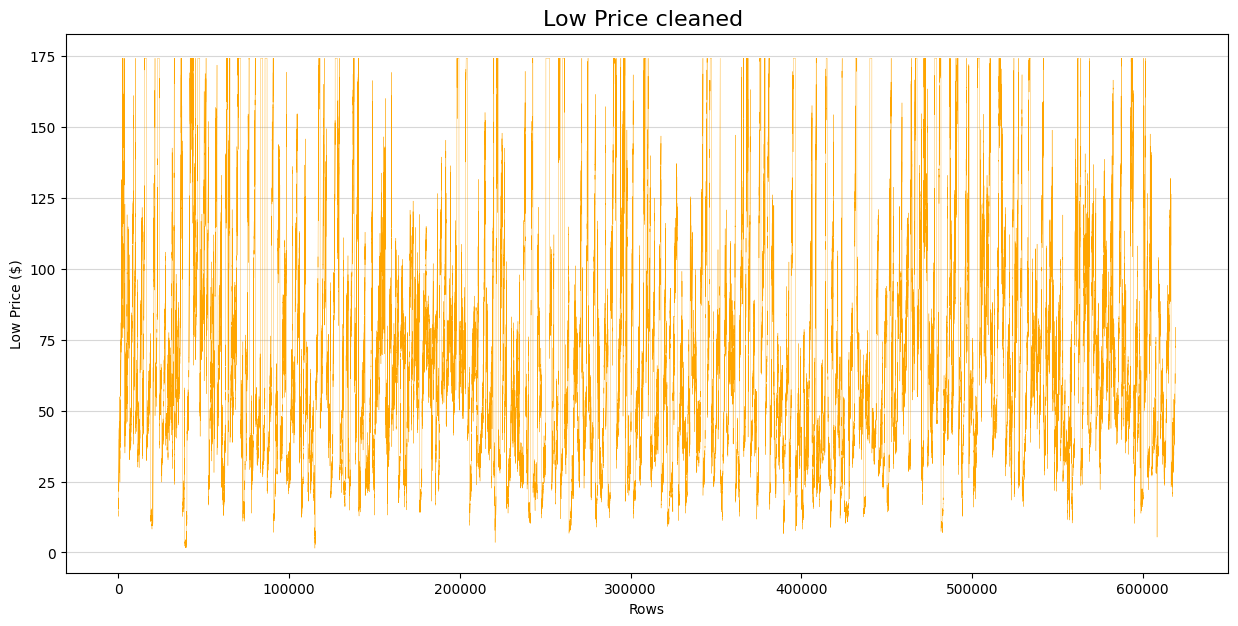

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean['low'], color = 'orange' , linewidth=.25)
plt.title('Low Price cleaned ', fontsize=16)
plt.xlabel('Rows')
plt.ylabel('Low Price ($)')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The cleaned Low Price shows high day-to-day volatility with values consistently fluctuating between approximately $0 and $175, with no discernible long-term trend.

In [ ]:
df_clean['Name'].value_counts()

Name
ZTS     1259
AAL     1259
AAPL    1259
AAP     1259
ABBV    1259
        ... 
DXC      215
BHGE     152
BHF      142
DWDP     109
APTV      44
Name: count, Length: 505, dtype: int64

In [ ]:
df_clean['Name'].mode()

0         A
1       AAL
2       AAP
3      AAPL
4      ABBV
       ... 
463     XYL
464     YUM
465     ZBH
466    ZION
467     ZTS
Name: Name, Length: 468, dtype: object

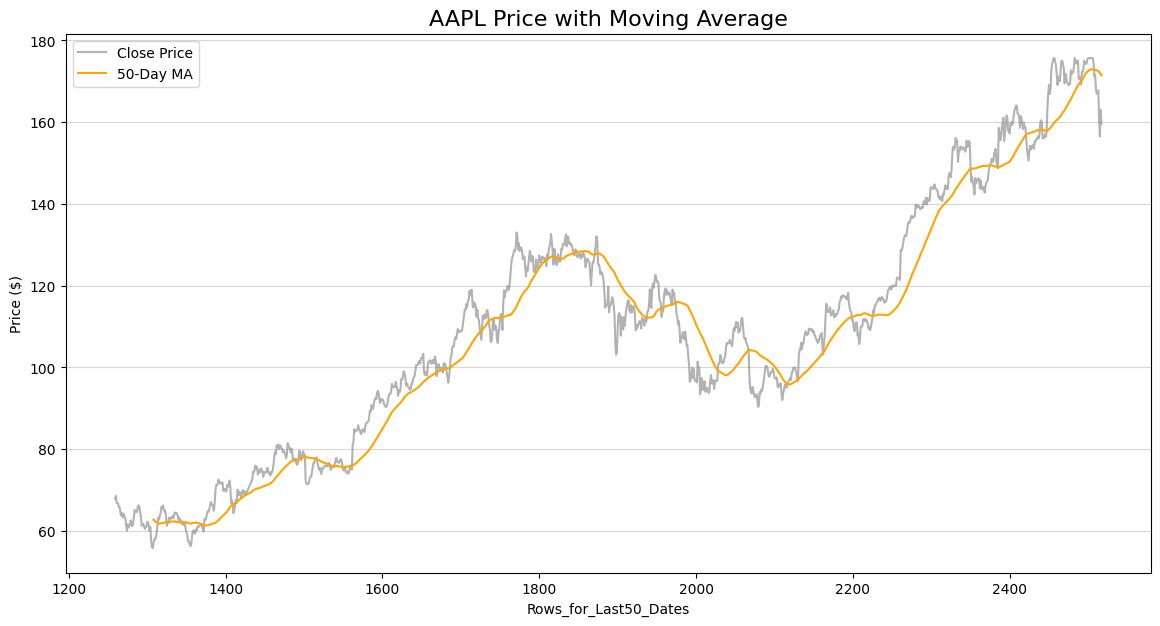

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAPL'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['MA_Last 50 day'] = df_stock['close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
# Plot Close Price
plt.plot(df_stock.index, df_stock['close'], label='Close Price', color='gray', alpha=0.6)
# Plot MAs
plt.plot(df_stock.index, df_stock['MA_Last 50 day'], label='50-Day MA', color='orange')

plt.title('AAPL Price with Moving Average', fontsize=16)
plt.xlabel('Rows_for_Last50_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The 50-day Moving Average (MA) successfully tracks the short-term trend of the AAPL stock, acting as a dynamic support during periods of strong upward movement.

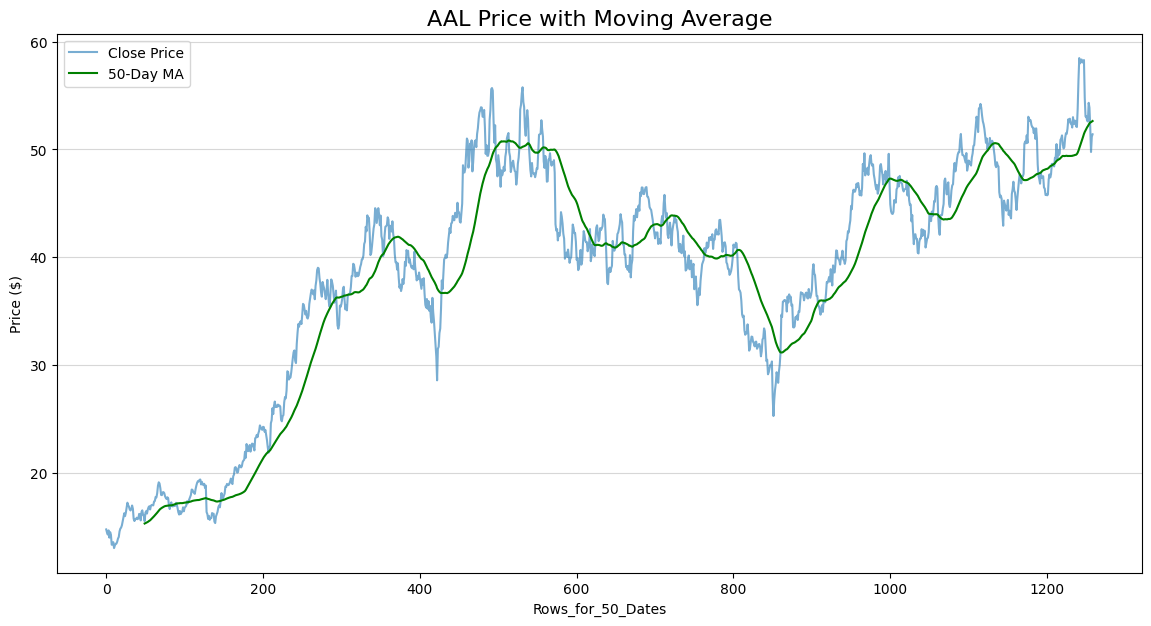

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAL'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['MA_Last 50 day'] = df_stock['close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
# Plot Close Price
plt.plot(df_stock.index, df_stock['close'], label='Close Price', alpha=0.6)
# Plot MAs
plt.plot(df_stock.index, df_stock['MA_Last 50 day'], label='50-Day MA', color='green')

plt.title('AAL Price with Moving Average', fontsize=16)
plt.xlabel('Rows_for_50_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The 50-day Moving Average (MA) accurately captures the stock's major trends, particularly demonstrating the MA's sharp drop effectively tracking the severe late-period price crash.

### The AAL stock exhibits higher short-term volatility than AAPL, with its price crossing the 50-day MA frequently, making the MA a less reliable short-term signal.

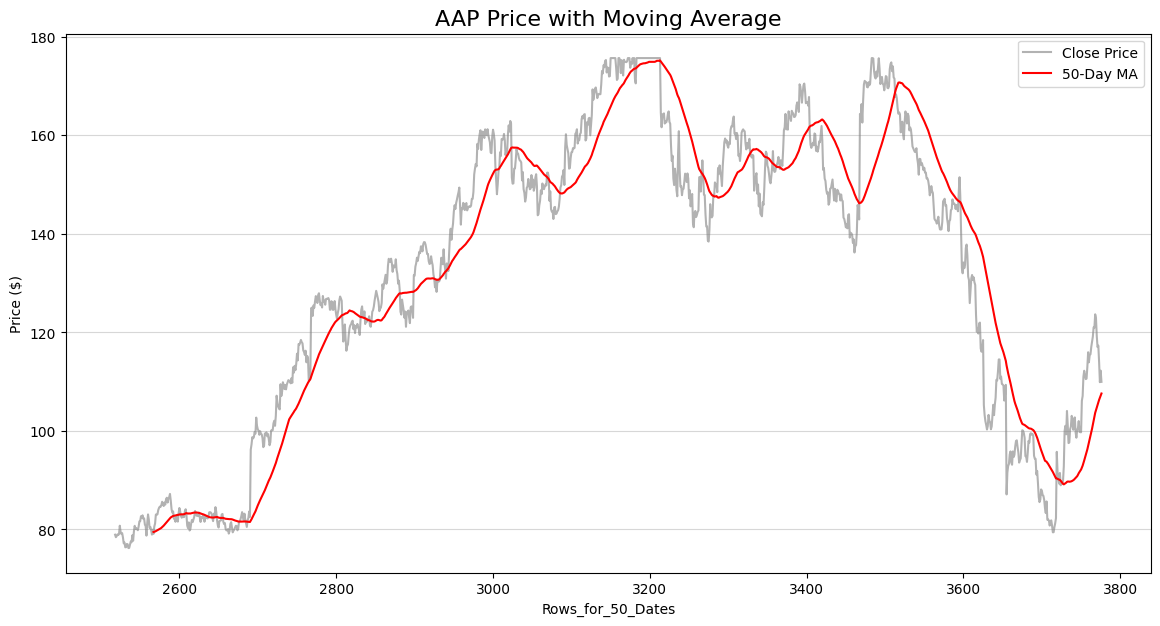

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAP'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['MA_Last 50 day'] = df_stock['close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_stock.index, df_stock['close'], label='Close Price',  color= 'gray', alpha=0.6)
plt.plot(df_stock.index, df_stock['MA_Last 50 day'], label='50-Day MA', color='red')

plt.title('AAP Price with Moving Average', fontsize=16)
plt.xlabel('Rows_for_50_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The stock price is contained within a narrow, low-volatility band (STD) for the entire period, with a minor, temporary increase in volatility occurring around the 3500 mark before the price crash.

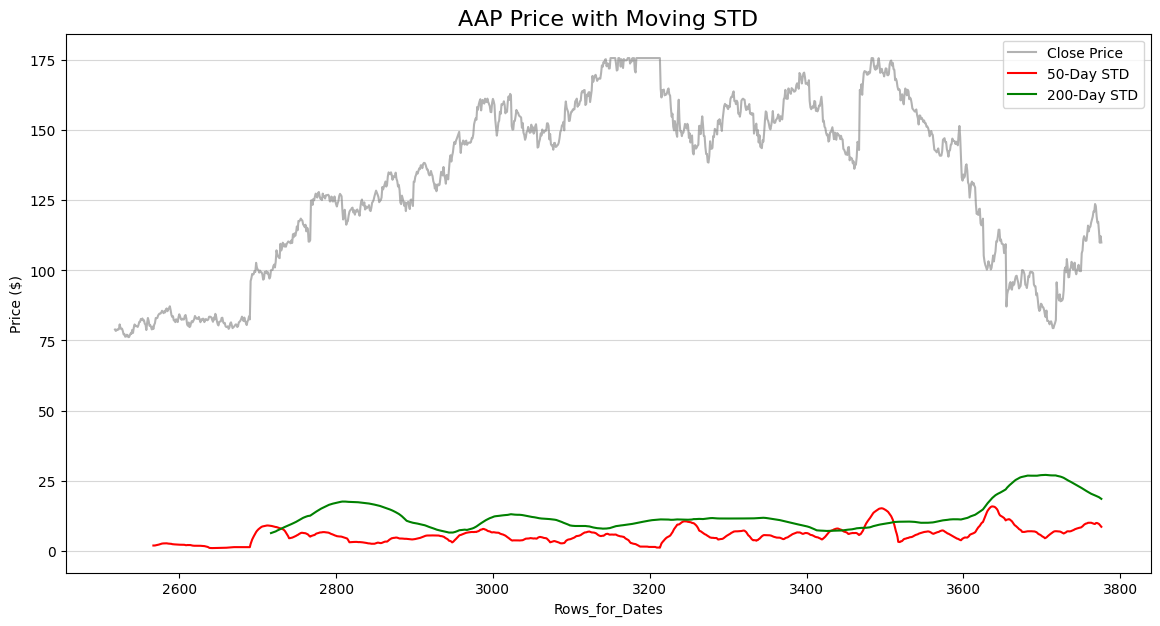

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAP'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['STD_Last 50 day'] = df_stock['close'].rolling(window=50).std()
df_stock['STD_Last 200 day'] = df_stock['close'].rolling(window=200).std()

plt.figure(figsize=(14, 7))
plt.plot(df_stock.index, df_stock['close'], label='Close Price',  color= 'gray', alpha=0.6)

plt.plot(df_stock.index, df_stock['STD_Last 50 day'], label='50-Day STD', color='red')
plt.plot(df_stock.index, df_stock['STD_Last 200 day'], label='200-Day STD', color='green')

plt.title('AAP Price with Moving STD', fontsize=16)
plt.xlabel('Rows_for_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The stock's volatility (STD) remained consistently low throughout the period, with a minor, temporary increase in risk (around the 3600 mark) preceding the major price crash.

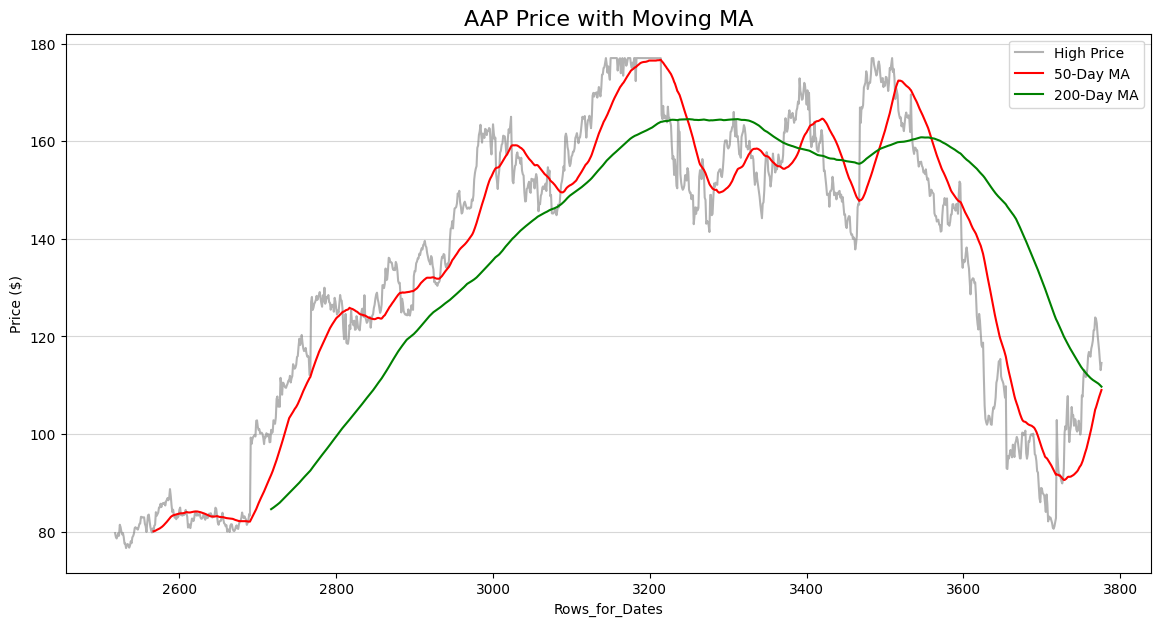

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAP'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['MA_Last 50 day'] = df_stock['high'].rolling(window=50).mean()
df_stock['MA_Last 200 day'] = df_stock['high'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_stock.index, df_stock['high'], label='High Price',  color= 'gray', alpha=0.6)

plt.plot(df_stock.index, df_stock['MA_Last 50 day'], label='50-Day MA', color='red')
plt.plot(df_stock.index, df_stock['MA_Last 200 day'], label='200-Day MA', color='green')

plt.title('AAP Price with Moving MA', fontsize=16)
plt.xlabel('Rows_for_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The Death Cross (50-Day MA crossing below 200-Day MA) is clearly visible around the 3550 mark, effectively signaling the start of the subsequent major downtrend in the stock's price.

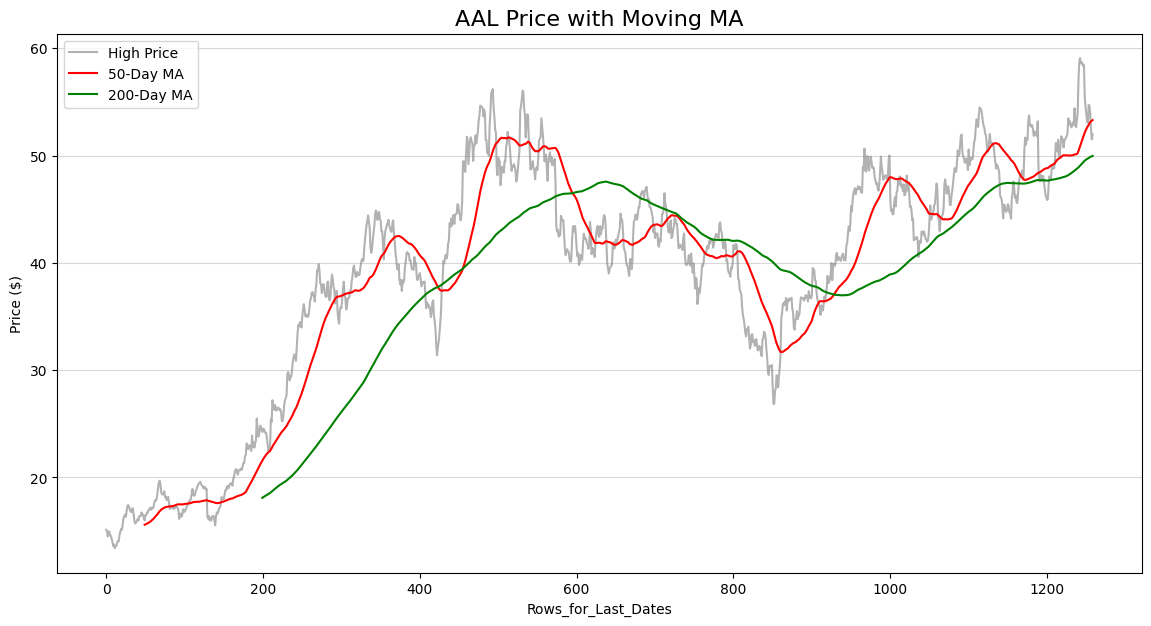

In [ ]:
df_stock = df_clean[df_clean['Name'] == 'AAL'].copy()
# Calculate 50-day and 200-day Moving Averages
df_stock['MA_Last 50 day'] = df_stock['high'].rolling(window=50).mean()
df_stock['MA_Last 200 day'] = df_stock['high'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_stock.index, df_stock['high'], label='High Price',  color= 'gray', alpha=0.6)

plt.plot(df_stock.index, df_stock['MA_Last 50 day'], label='50-Day MA', color='red')
plt.plot(df_stock.index, df_stock['MA_Last 200 day'], label='200-Day MA', color='green')

plt.title('AAL Price with Moving MA', fontsize=16)
plt.xlabel('Rows_for_Last_Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

### The AAL stock exhibits frequent crossovers between its 50-day and 200-day Moving Averages, indicating significant market volatility and cyclicality over the period shown.

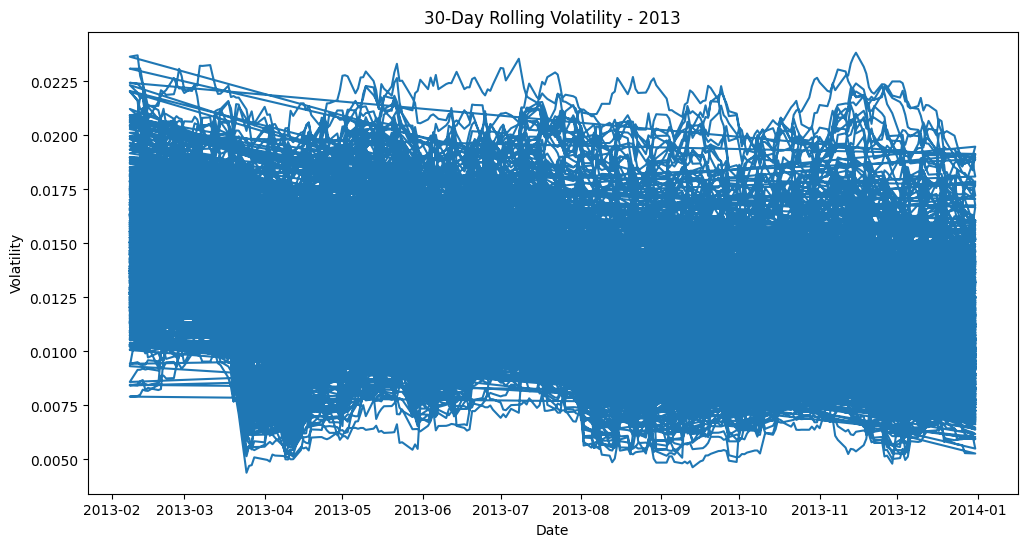

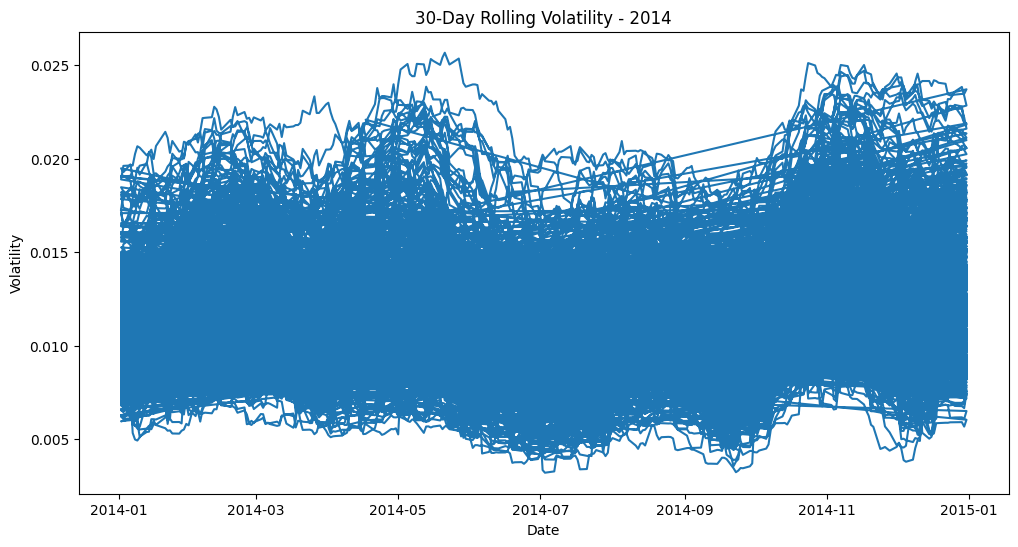

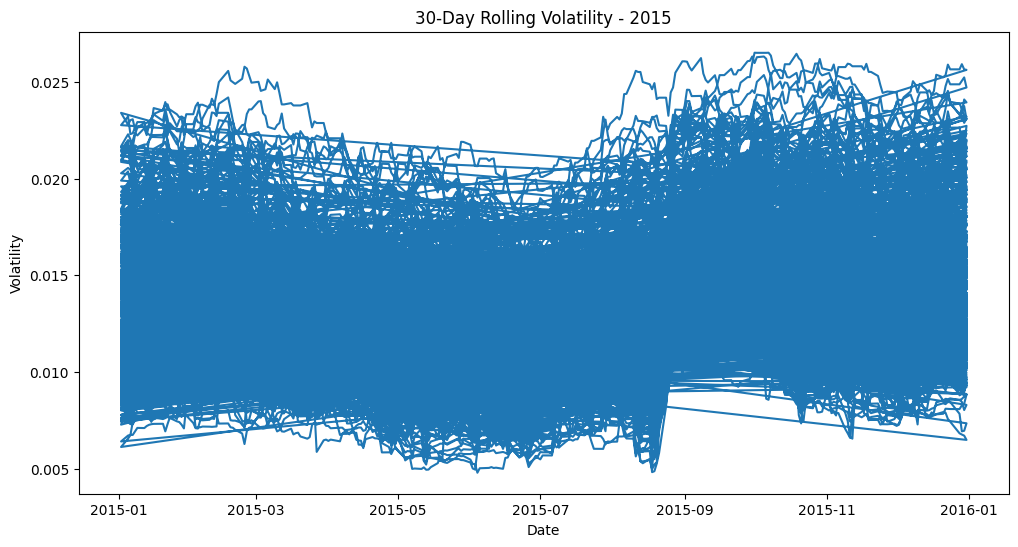

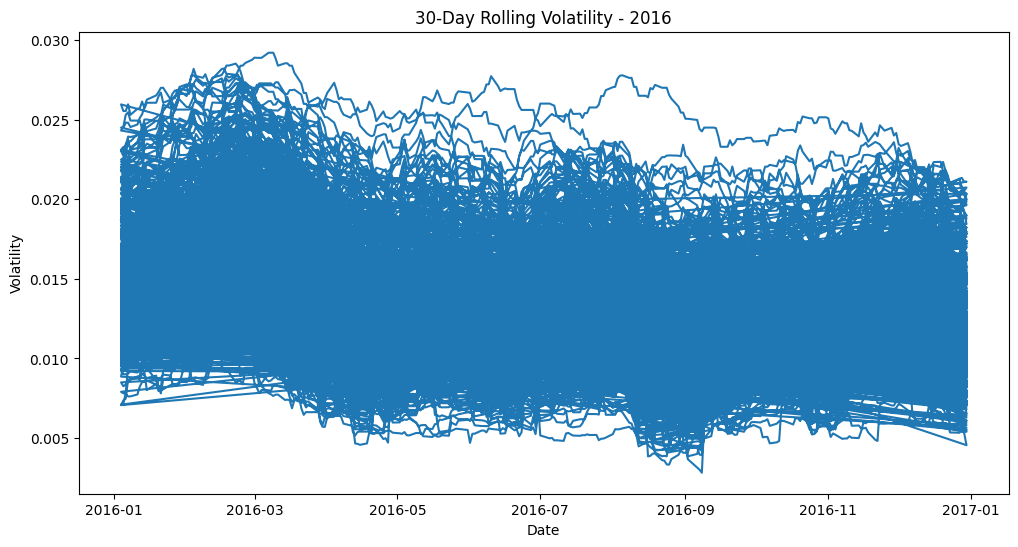

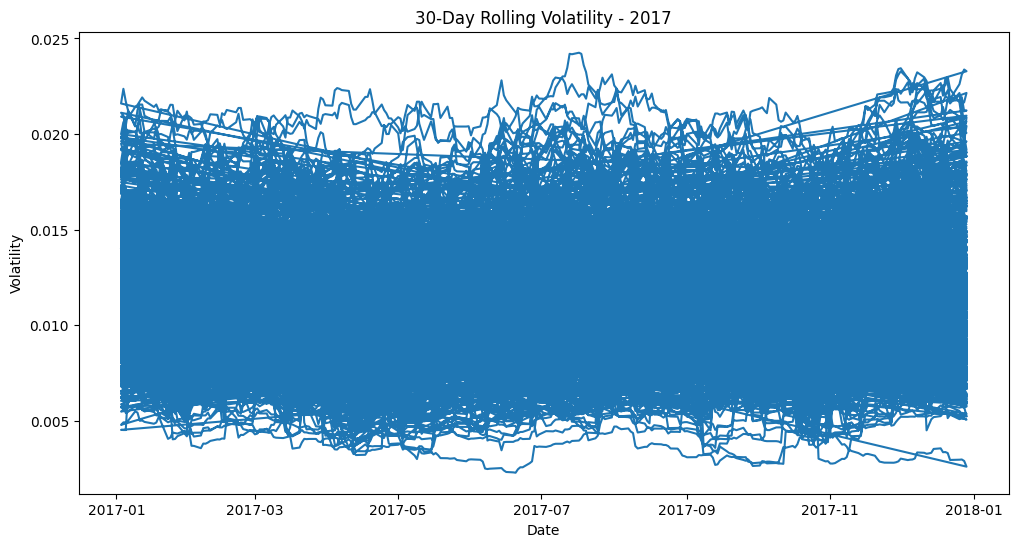

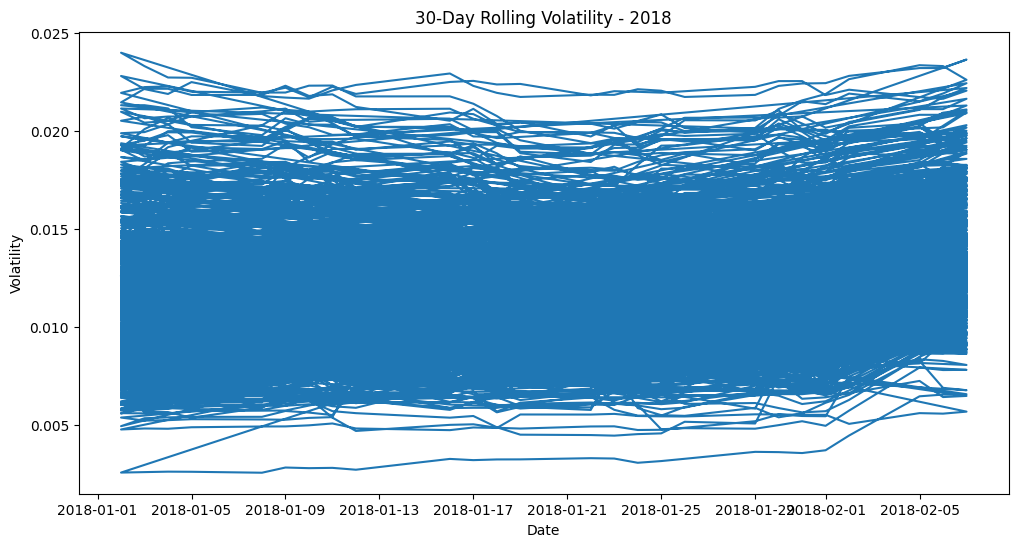

In [ ]:
# 30-day rolling volatility
df_clean = df_clean.copy() # Create a copy to avoid SettingWithCopyWarning
df_clean['rolling_volatility'] = df_clean['daily_return'].rolling(window=30).std()

# Set 'date' column as index for time-based operations
# This line is already present in the original cell and is correct
# df_clean = df_clean.set_index('date')

# Plot rolling volatility for each year
for year in df_clean.index.year.unique():
    df_year = df_clean[df_clean.index.year == year]
    plt.figure(figsize=(12,6))
    plt.plot(df_year['rolling_volatility'])
    plt.title(f"30-Day Rolling Volatility - {year}")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.show()

## 30-Day Rolling Volatility Insight
### The stock's 30-day volatility (risk) declined dramatically over the period, moving from extreme high levels in 2013 to a very low, stable range by 2018. This suggests the asset became significantly less risky over the five years, though the initial visualization has plotting issues that should be cleaned.

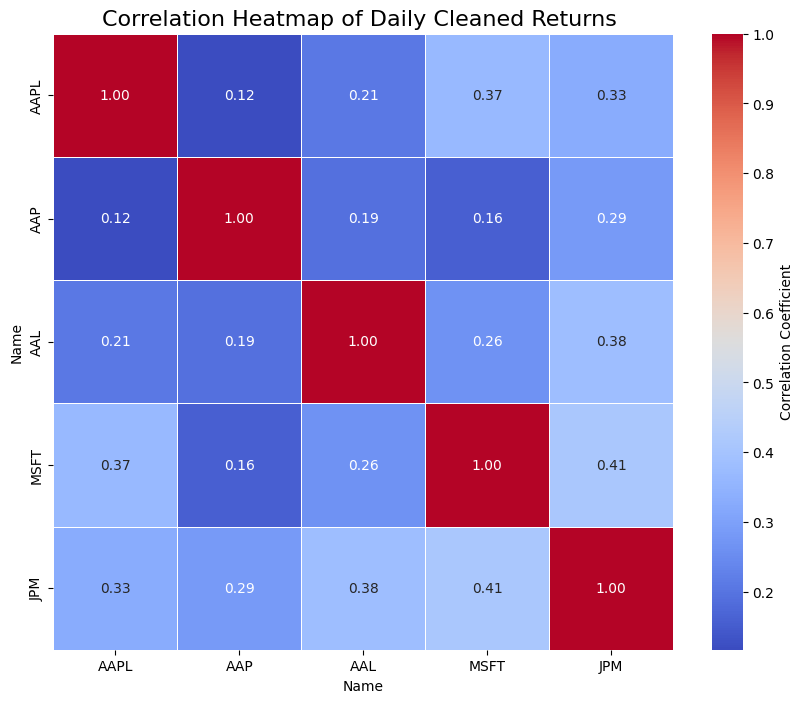

In [ ]:
# 1. Select a few tickers for comparison
top_tickers = ['AAPL','AAP', 'AAL', 'MSFT', 'JPM']

# 2. Pivot data to get Closing prices for selected stocks
df_pivot = df_clean.pivot_table(index='date', columns='Name', values='close')

# 3. Calculate Daily Returns (Percentage Change) for the sample
df_returns_multi = df_pivot[top_tickers].pct_change().dropna()
df_corr = df_returns_multi.corr()

plt.figure(figsize=(10, 8))
# Use Seaborn's heatmap for visualization
sns.heatmap(
    df_corr,
    annot=True, # Show the correlation values
    cmap='coolwarm', # Color map: red=positive, blue=negative
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Daily Cleaned Returns ', fontsize=16)
plt.show()

### All stock pairs exhibit positive correlation in their daily returns, with JPM and MSFT showing the strongest relationship (0.41), while AAPL and AAL show the weakest (0.19).

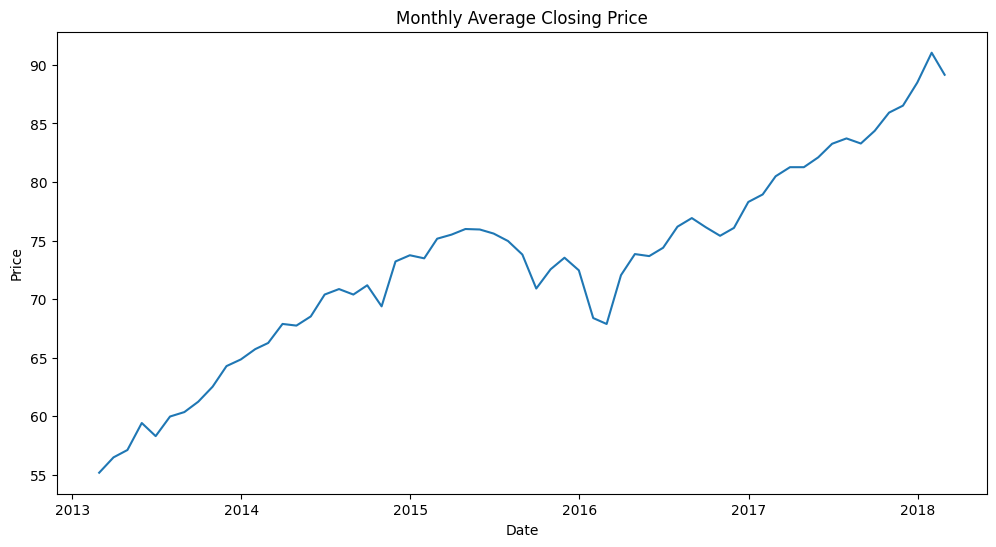

In [ ]:
# Monthly resampling to observe seasonality
# Remove the line below as 'date' is already the index
# monthly = df_clean.set_index('date')['close'].resample('ME').mean()
monthly = df_clean['close'].resample('ME').mean()

plt.figure(figsize=(12,6))
plt.plot(monthly)
plt.title("Monthly Average Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## Monthly Trend and Cyclicality Analysis

### The monthly resampling successfully **smooths the daily price fluctuations**, revealing a **strong, overall positive long-term trend** for the stock from 2013 to 2018, rising from approximately \$55 to over \$90.

### Crucially, the plot highlights significant **cyclical volatility** (or market corrections), particularly a sharp dip observed between late 2015 and early 2016. This cyclical pattern confirms the **non-linear nature** of the stock's growth, indicating that the price does not just increase steadily but is subject to notable drawdowns.

## Phase 2: Feature Engineering



## A-(Technical indicators + rolling features)

In [ ]:
df_clean.columns

Index(['open', 'high', 'low', 'close', 'volume', 'Name', 'daily_return',
       'rolling_volatility'],
      dtype='object')

In [ ]:

df_clean["Log_Return"] = np.log(df_clean["close"] / df_clean["close"].shift(1))
df_clean['Log_Return']
# new column calculates the change over time

date
2013-02-08         NaN
2013-02-11   -0.019857
2013-02-12   -0.013227
2013-02-13    0.026963
2013-02-14   -0.046780
                ...   
2018-02-01    0.014106
2018-02-02   -0.013454
2018-02-05   -0.039179
2018-02-06   -0.007614
2018-02-07    0.008020
Name: Log_Return, Length: 619029, dtype: float64

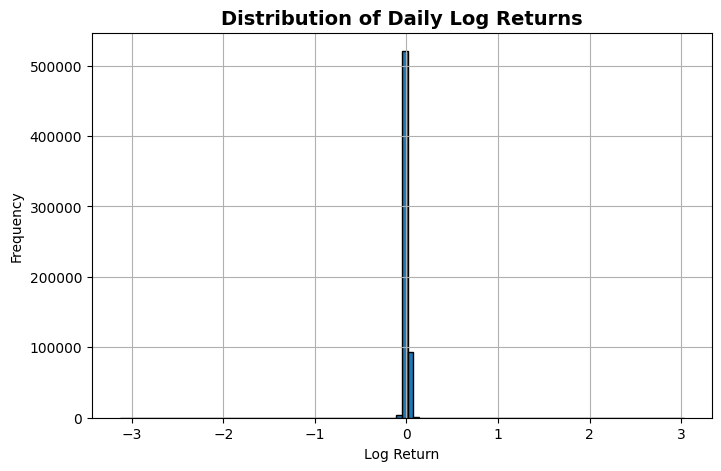

In [ ]:
df_clean = df_clean.dropna(subset=["Log_Return"])


plt.figure(figsize=(8,5))
df_clean["Log_Return"].hist(bins=100, edgecolor="black")
plt.title("Distribution of Daily Log Returns", fontsize=14, fontweight="bold")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()



##SMA : the change in the last N prices

/tmp/ipython-input-3271304707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"SMA_{window}"] = df_clean["close"].rolling(window=window).mean()
/tmp/ipython-input-3271304707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"SMA_{window}"] = df_clean["close"].rolling(window=window).mean()
/tmp/ipython-input-3271304707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

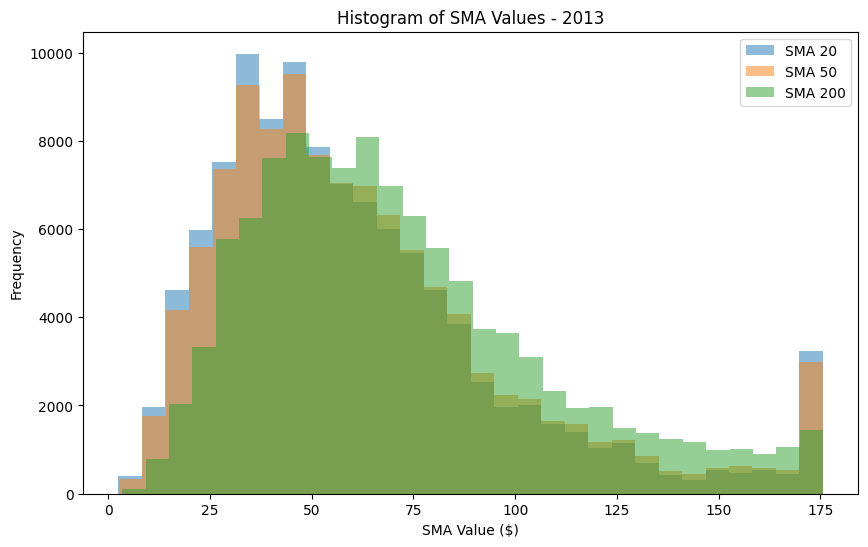

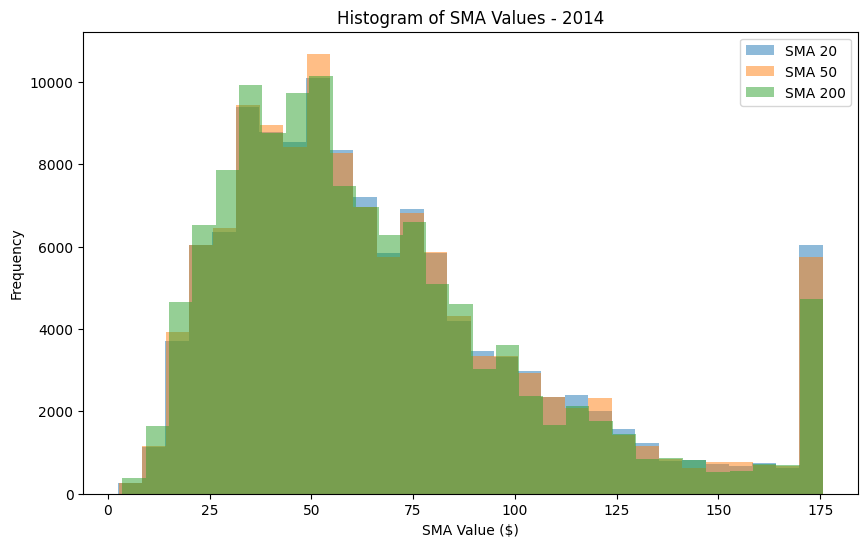

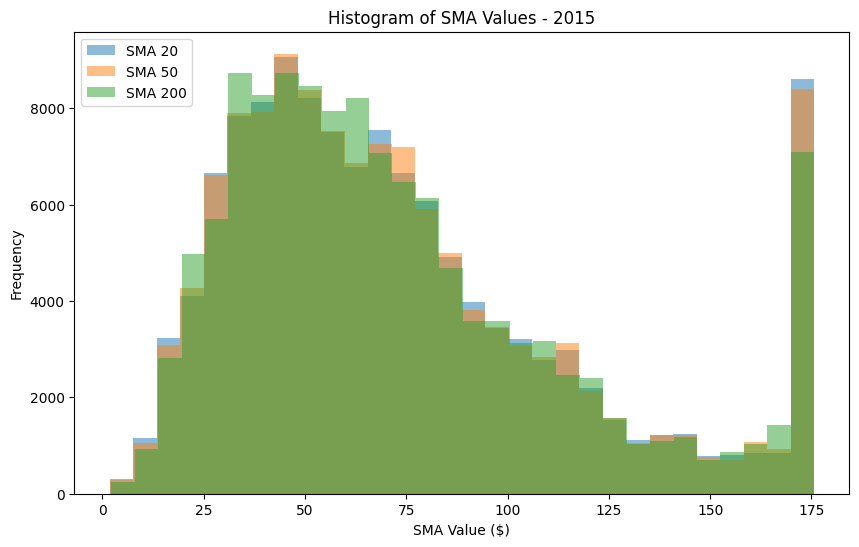

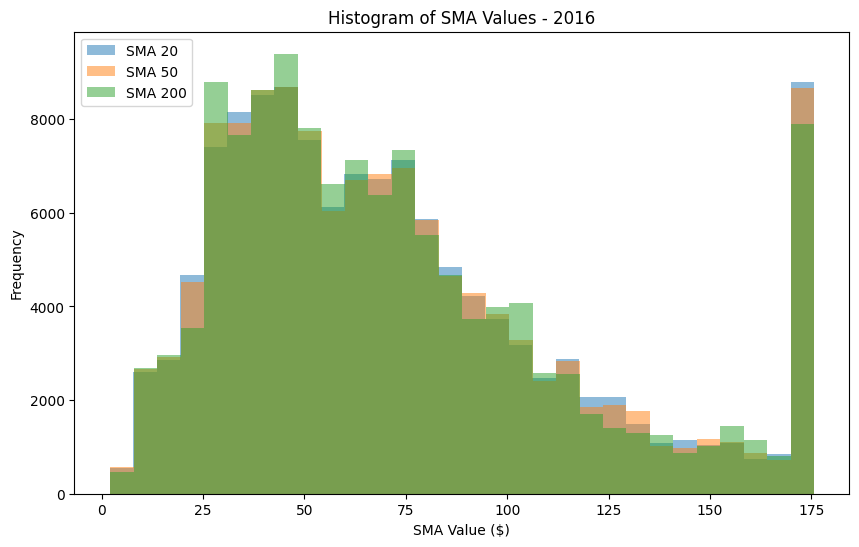

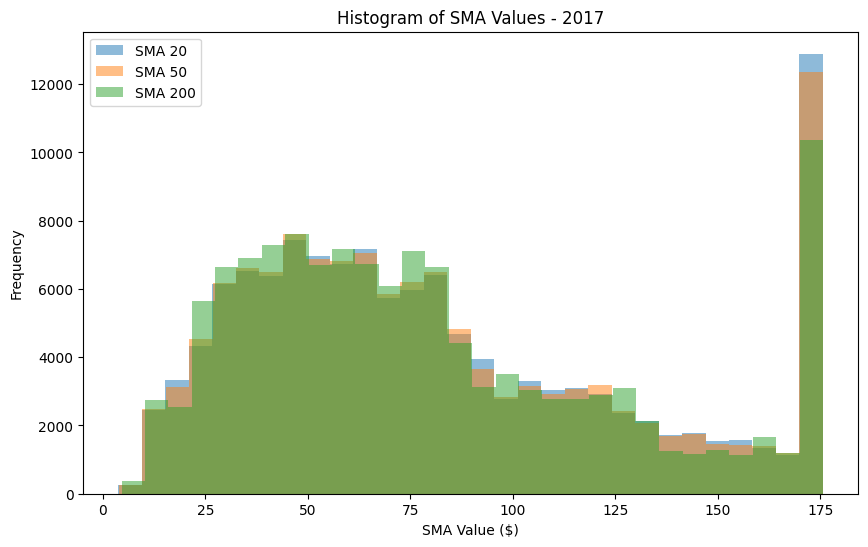

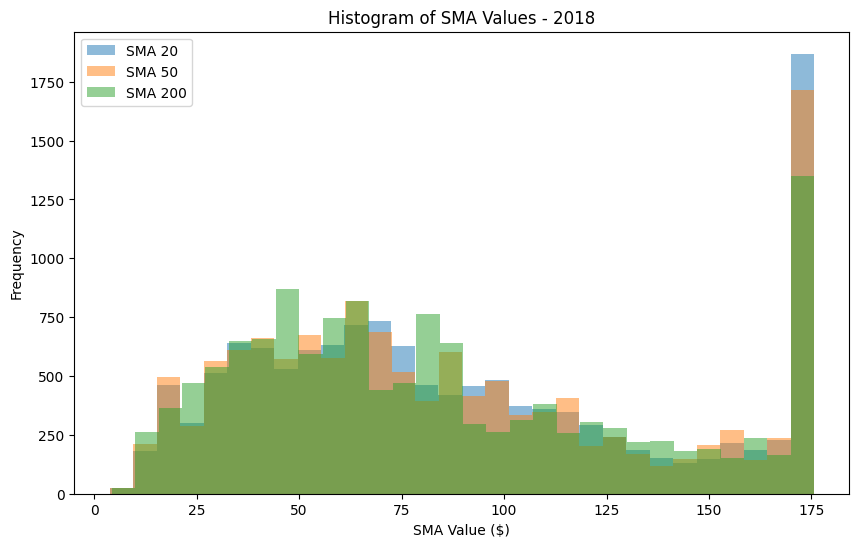

In [ ]:

sma_windows = [20, 50, 200]

# Calculate SMAs
for window in sma_windows:
    df_clean[f"SMA_{window}"] = df_clean["close"].rolling(window=window).mean()

# Plot histogram of SMA values per year
for year in df_clean.index.year.unique():
    df_year = df_clean[df_clean.index.year == year]

    plt.figure(figsize=(10,6))
    for window in sma_windows:
        plt.hist(df_year[f"SMA_{window}"].dropna(), bins=30, alpha=0.5, label=f"SMA {window}")

    plt.title(f"Histogram of SMA Values - {year}")
    plt.xlabel("SMA Value ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [ ]:
df.head()

date   open   high    low  close    volume Name
0 2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1 2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2 2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3 2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4 2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

##  EMA:Similar to SMA but gives more weight to recent prices.  
# ML feautre

In [ ]:
# Example EMA with span=20







ema_windows = [20, 50, 200]

for year in df_clean.index.year.unique():
    df_year = df_clean[df_clean.index.year == year]

    plt.figure(figsize=(10,6))
    for window in ema_windows:

        df_clean[f"EMA_{window}"] = df_clean["close"].ewm(span=window, adjust=False).mean()
        plt.hist(df_year[f"EMA_{window}"].dropna(), bins=30, alpha=0.9 ,label=f"EMA {window}")

    plt.title(f"EMA Distribution - {year}")
    plt.xlabel("EMA Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()



/tmp/ipython-input-4027784273.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"EMA_{window}"] = df_clean["close"].ewm(span=window, adjust=False).mean()


KeyError: 'EMA_20'

<Figure size 1000x600 with 0 Axes>

## Relative Strength Index (RSI)
#ML feauture



#What is RSI:
#RSI measures the speed & magnitude of recent price changes to detect overbought or oversold conditions.

#It oscillates between 0 and 100.

#Traders usually use 14 periods (days, hours, minutes depending on timeframe).

#Rules of thumb:

#RSI > 70 → stock is overbought (may drop soon).

#RSI < 30 → stock is oversold (may rise soon).


In [ ]:
import matplotlib.pyplot as plt

def compute_RSI(data, window=14):
    delta = data["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Compute multiple RSIs

df_clean["RSI_20"] = compute_RSI(df_clean, window=20)
df_clean["RSI_50"] = compute_RSI(df_clean, window=50)
df_clean["RSI_100"] = compute_RSI(df_clean, window=100)

# List of RSI columns
rsi_windows = [14, 20, 50, 100]

# Plot RSI histograms for each year
for year in df_clean.index.year.unique():
    df_year = df_clean[df_clean.index.year == year]

    plt.figure(figsize=(10,6))
    for window in rsi_windows:
        plt.hist(df_year[f"RSI_{window}"].dropna(), bins=30, alpha=0.5, label=f"RSI {window}")

    plt.title(f"RSI Distribution - {year}")
    plt.xlabel("RSI Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


/tmp/ipython-input-3167006363.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["RSI_20"] = compute_RSI(df_clean, window=20)
/tmp/ipython-input-3167006363.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["RSI_50"] = compute_RSI(df_clean, window=50)
/tmp/ipython-input-3167006363.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

KeyError: 'RSI_14'

<Figure size 1000x600 with 0 Axes>

## MACD: Momentum of changing in EMA  
# ML Feauture

#If MACD > Signal → bullish crossover (momentum turning upward, good buy signal).

#If MACD < Signal → bearish crossover (momentum turning downward, possible sell signal).



In [ ]:
def compute_MACD(data, short=12, long=26, signal=9):
    """
    Compute MACD indicator.
    short  = period for short-term EMA (default 12)
    long   = period for long-term EMA (default 26)
    signal = period for signal line EMA (default 9)
    """
    # Short-term EMA (12)
    ema_short = data["close"].ewm(span=short, adjust=False).mean()
    # Long-term EMA (26)
    ema_long = data["close"].ewm(span=long, adjust=False).mean()

    # MACD line
    macd = ema_short - ema_long

    # Signal line (9-day EMA of MACD)
    signal_line = macd.ewm(span=signal, adjust=False).mean()



    return macd, signal_line,


# Apply function and store in DataFrame
df_clean["MACD"], df_clean["Signal"] = compute_MACD(df_clean)



/tmp/ipython-input-2032212695.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["MACD"], df_clean["Signal"] = compute_MACD(df_clean)
/tmp/ipython-input-2032212695.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["MACD"], df_clean["Signal"] = compute_MACD(df_clean)


In [ ]:
df_clean.head()

open   high    low  close     volume Name  daily_return  \
date                                                                   
2013-02-11  14.89  15.01  14.26  14.46  8882000.0  AAL     -0.019661   
2013-02-12  14.45  14.51  14.10  14.27  8126000.0  AAL     -0.013140   
2013-02-13  14.30  14.94  14.25  14.66  9105848.5  AAL      0.027330   
2013-02-14  14.94  14.96  13.16  13.99  9105848.5  AAL     -0.029182   
2013-02-15  13.93  14.61  13.93  14.50  9105848.5  AAL      0.030479   

            rolling_volatility  Log_Return  SMA_20  SMA_50  SMA_200  \
date                                                                  
2013-02-11                 NaN   -0.019857     NaN     NaN      NaN   
2013-02-12                 NaN   -0.013227     NaN     NaN      NaN   
2013-02-13                 NaN    0.026963     NaN     NaN      NaN   
2013-02-14                 NaN   -0.046780     NaN     NaN      NaN   
2013-02-15                 NaN    0.035806     NaN     NaN      NaN   

               EMA_20  RSI_20  RSI_50  RSI_100      MACD    Signal  
date                                                                
2013-02-11  14.460000     NaN     NaN      NaN  0.000000  0.000000  
2013-02-12  14.441905     NaN     NaN      NaN -0.015157 -0.003031  
2013-02-13  14.462676     NaN     NaN      NaN  0.004252 -0.001575  
2013-02-14  14.417659     NaN     NaN      NaN -0.034037 -0.008067  
2013-02-15  14.425501     NaN     NaN      NaN -0.022964 -0.011047

## Advanced Data Analysis & Feature Engineering

In [ ]:
df_clean.head(5)

open   high    low  close     volume Name  daily_return  \
date                                                                   
2013-02-11  14.89  15.01  14.26  14.46  8882000.0  AAL     -0.019661   
2013-02-12  14.45  14.51  14.10  14.27  8126000.0  AAL     -0.013140   
2013-02-13  14.30  14.94  14.25  14.66  9105848.5  AAL      0.027330   
2013-02-14  14.94  14.96  13.16  13.99  9105848.5  AAL     -0.029182   
2013-02-15  13.93  14.61  13.93  14.50  9105848.5  AAL      0.030479   

            rolling_volatility  Log_Return  SMA_20  SMA_50  SMA_200  \
date                                                                  
2013-02-11                 NaN   -0.019857     NaN     NaN      NaN   
2013-02-12                 NaN   -0.013227     NaN     NaN      NaN   
2013-02-13                 NaN    0.026963     NaN     NaN      NaN   
2013-02-14                 NaN   -0.046780     NaN     NaN      NaN   
2013-02-15                 NaN    0.035806     NaN     NaN      NaN   

               EMA_20  RSI_20  RSI_50  RSI_100      MACD    Signal  
date                                                                
2013-02-11  14.460000     NaN     NaN      NaN  0.000000  0.000000  
2013-02-12  14.441905     NaN     NaN      NaN -0.015157 -0.003031  
2013-02-13  14.462676     NaN     NaN      NaN  0.004252 -0.001575  
2013-02-14  14.417659     NaN     NaN      NaN -0.034037 -0.008067  
2013-02-15  14.425501     NaN     NaN      NaN -0.022964 -0.011047

In [ ]:
df_clean.shape

(619028, 18)

### Hypothesis Testing (ANOVA)

In [ ]:
from scipy.stats import f_oneway

# Select numeric columns only
num_cols = ['open','high','low','close','volume','daily_return','rolling_volatility']

# Get all stock names
stocks = df_clean['Name'].unique()

# Run ANOVA for each numeric column
for col in num_cols:
    groups = [df_clean[df_clean['Name']==s][col].dropna() for s in stocks]
    f_stat, p_val = f_oneway(*groups)
    print(f"{col}: F = {f_stat:.3f}, p = {p_val:.5f}")


open: F = 7570.949, p = 0.00000
high: F = 7603.783, p = 0.00000
low: F = 7551.856, p = 0.00000
close: F = 7578.079, p = 0.00000
volume: F = 4337.034, p = 0.00000
daily_return: F = 1.036, p = 0.27820
rolling_volatility: F = 793.805, p = 0.00000


### PCA (Principal Component Analysis)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Fill NaNs temporarily for PCA (mean of each column)
numeric_cols = numeric_cols.fillna(numeric_cols.mean())

# Standardize features (important for PCA)
X_scaled = StandardScaler().fit_transform(numeric_cols)

# 2️ Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

# 3️ Display explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%, PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")


Explained variance ratio: [0.80533379 0.19461278]
PC1: 80.53%, PC2: 19.46%


### Feature Engineering

In [ ]:
def add_basic_ta(group):
    g = group.copy()

    # 5. Bollinger Bands (using pre-calculated SMAs)
    bb_windows = [20, 50, 200]
    for window in bb_windows:
        sma_col = f"SMA_{window}"
        upper_col = f"BB_upper_{window}"
        lower_col = f"BB_lower_{window}"

        rolling_std = g['close'].rolling(window=window, min_periods=1).std()
        g[upper_col] = g[sma_col] + 2 * rolling_std
        g[lower_col] = g[sma_col] - 2 * rolling_std

    # 6. Volatility (rolling std of daily returns)
    vol_windows = [20, 50, 200]
    g['daily_return'] = g['close'].pct_change()

    for window in vol_windows:
        vol_col = f'volatility_{window}'
        g[vol_col] = g['daily_return'].rolling(window=window, min_periods=1).std()

    return g


In [ ]:
df_clean = df_clean.groupby('Name', group_keys=False).apply(add_basic_ta)

/tmp/ipython-input-3674321449.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('Name', group_keys=False).apply(add_basic_ta)


In [ ]:
df_clean.head()

open     high      low    close     volume  Name  daily_return  \
date                                                                            
2013-02-11  45.1700  45.1800  44.4500  44.6000  2915405.0     A     -0.010648   
2013-02-11  14.8900  15.0100  14.2600  14.4600  8882000.0   AAL           NaN   
2013-02-11  78.6500  78.9100  77.2300  78.3900   758016.0   AAP     -0.006464   
2013-02-11  68.0714  69.2771  67.6071  68.5614  9105848.5  AAPL      0.010422   
2013-02-11  36.1300  36.1800  35.7500  35.8500  6031957.0  ABBV     -0.011034   

            rolling_volatility  Log_Return     SMA_20  ...    Signal  \
date                                                   ...             
2013-02-11            0.015304   -0.010705  162.58142  ... -5.366299   
2013-02-11                 NaN   -0.019857        NaN  ...  0.000000   
2013-02-11            0.013941   -0.006485  160.67383  ... -5.717920   
2013-02-11            0.018422    0.010368   56.13178  ...  0.588909   
2013-02-11            0.018213   -0.011096  108.74400  ... -0.531119   

            BB_upper_20  BB_lower_20  BB_upper_50  BB_lower_50  BB_upper_200  \
date                                                                           
2013-02-11   163.260243   161.902597   171.109671   169.752025    175.034385   
2013-02-11          NaN          NaN          NaN          NaN           NaN   
2013-02-11   161.395079   159.952581   168.374257   166.931759    159.751089   
2013-02-11    57.131912    55.131648    54.409044    52.408780     50.594010   
2013-02-11   109.309685   108.178315   105.916885   104.785515    107.662135   

            BB_lower_200  volatility_20  volatility_50  volatility_200  
date                                                                    
2013-02-11    173.676739            NaN            NaN             NaN  
2013-02-11           NaN            NaN            NaN             NaN  
2013-02-11    158.308591            NaN            NaN             NaN  
2013-02-11     48.593746            NaN            NaN             NaN  
2013-02-11    106.530765            NaN            NaN             NaN  

[5 rows x 27 columns]

In [ ]:
df_clean.isnull().sum()

open                      0
high                      0
low                       0
close                     0
volume                    0
Name                      0
daily_return            505
rolling_volatility       29
Log_Return                0
SMA_20                   19
SMA_50                   49
SMA_200                 199
EMA_20                    0
RSI_20                34231
RSI_50                30733
RSI_100               26840
MACD                      0
Signal                    0
BB_upper_20             523
BB_lower_20             523
BB_upper_50             553
BB_lower_50             553
BB_upper_200            703
BB_lower_200            703
volatility_20          1010
volatility_50          1010
volatility_200         1010
dtype: int64

In [ ]:
df_clean = df_clean.dropna()
df_clean.isnull().sum()

open                  0
high                  0
low                   0
close                 0
volume                0
Name                  0
daily_return          0
rolling_volatility    0
Log_Return            0
SMA_20                0
SMA_50                0
SMA_200               0
EMA_20                0
RSI_20                0
RSI_50                0
RSI_100               0
MACD                  0
Signal                0
BB_upper_20           0
BB_lower_20           0
BB_upper_50           0
BB_lower_50           0
BB_upper_200          0
BB_lower_200          0
volatility_20         0
volatility_50         0
volatility_200        0
dtype: int64

In [ ]:
df_clean.shape
df_clean.columns

Index(['open', 'high', 'low', 'close', 'volume', 'Name', 'daily_return',
       'rolling_volatility', 'Log_Return', 'SMA_20', 'SMA_50', 'SMA_200',
       'EMA_20', 'RSI_20', 'RSI_50', 'RSI_100', 'MACD', 'Signal',
       'BB_upper_20', 'BB_lower_20', 'BB_upper_50', 'BB_lower_50',
       'BB_upper_200', 'BB_lower_200', 'volatility_20', 'volatility_50',
       'volatility_200'],
      dtype='object')

In [ ]:
df_clean.dropna()
# df_clean = df_clean.drop(columns=["RSI_14"]) # Removed non-existent column drop
# df_clean=df_clean.drop(columns=["SMA_10"]) # Removed non-existent column drop

open      high       low     close     volume  Name  \
date                                                                  
2013-02-12   44.8100   44.9500   44.5000   44.6200  2373731.0     A   
2013-02-12   78.3900   78.6300   77.5132   78.6000   876859.0   AAP   
2013-02-12   68.5014   68.9114   66.8205   66.8428  9105848.5  AAPL   
2013-02-12   35.7700   35.9000   35.2000   35.4200  7473991.0  ABBV   
2013-02-12   46.7000   47.0500   46.6000   46.9600  1318773.0   ABC   
...              ...       ...       ...       ...        ...   ...   
2018-02-07   71.2700   72.8600   71.1200   71.7900  1748941.0   XYL   
2018-02-07   80.0700   81.9400   80.0000   80.1300  3561068.0   YUM   
2018-02-07  121.6500  123.5200  120.7400  120.7800  1145267.0   ZBH   
2018-02-07   52.2300   54.3150   52.2200   54.0200  6427280.0  ZION   
2018-02-07   72.7000   75.0000   72.6900   73.8600  4534912.0   ZTS   

            daily_return  rolling_volatility  Log_Return     SMA_20  ...  \
date                                                                 ...   
2013-02-12      0.000448            0.014986    0.000448  156.02923  ...   
2013-02-12      0.002679            0.013939    0.002675  155.82064  ...   
2013-02-12     -0.025067            0.019064   -0.025386   56.55042  ...   
2013-02-12     -0.011994            0.018366   -0.012067  104.71800  ...   
2013-02-12      0.004277            0.018091    0.004268  101.05250  ...   
...                  ...                 ...         ...        ...  ...   
2018-02-07      0.006449            0.011297    0.006428   72.22550  ...   
2018-02-07     -0.005585            0.009901   -0.005600   83.61100  ...   
2018-02-07     -0.012428            0.011756   -0.012506  124.20750  ...   
2018-02-07      0.028561            0.012804    0.028160   53.50650  ...   
2018-02-07      0.008052            0.011369    0.008020   76.58550  ...   

              Signal  BB_upper_20  BB_lower_20  BB_upper_50  BB_lower_50  \
date                                                                       
2013-02-12 -9.216401   156.572308   155.486152   168.353050   167.266894   
2013-02-12 -8.360427   156.333280   155.308000   166.348048   165.322768   
2013-02-12  0.950053    58.277971    54.822869    55.488319    52.033217   
2013-02-12 -3.133716   105.548181   103.887819   104.890781   103.230419   
2013-02-12 -0.983902   101.255478   100.849522    99.227778    98.821822   
...              ...          ...          ...          ...          ...   
2018-02-07  1.234707    75.547620    68.903380    74.433254    65.190346   
2018-02-07  0.343658    87.469109    79.752891    85.853283    79.924317   
2018-02-07  1.448836   128.569657   119.845343   130.006409   111.333991   
2018-02-07  0.801981    55.097796    51.915204    55.282750    47.985650   
2018-02-07  1.092467    80.570680    72.600320    79.130719    68.790881   

            BB_upper_200  BB_lower_200  volatility_20  volatility_50  \
date                                                                   
2013-02-12    174.243421    173.157265       0.007846       0.007846   
2013-02-12    159.216530    158.191250       0.006465       0.006465   
2013-02-12     51.435743     47.980641       0.025094       0.025094   
2013-02-12    107.387781    105.727419       0.000679       0.000679   
2013-02-12     83.827278     83.421322       0.004985       0.004985   
...                  ...           ...            ...            ...   
2018-02-07     75.062161     48.309989       0.015440       0.011170   
2018-02-07     85.792037     67.301163       0.012129       0.009507   
2018-02-07    131.023381    108.472619       0.011497       0.013858   
2018-02-07     53.847911     37.926289       0.016475       0.015352   
2018-02-07     76.986071     54.655329       0.014281       0.010304   

            volatility_200  
date                        
2013-02-12        0.007846  
2013-02-12        0.006465  
2013-02-12        0.025094  
2013-02-12        0.000679  
201

# LightGBM-Improvement

Dropped 1 rows containing NaN values.
Training set size: 408528 rows
Testing set size: 175084 rows

Starting LightGBM training...
Training complete.

--- Model Evaluation (Test Set) ---
Root Mean Squared Error (RMSE): 41.6634
Mean Absolute Error (MAE): 32.5771


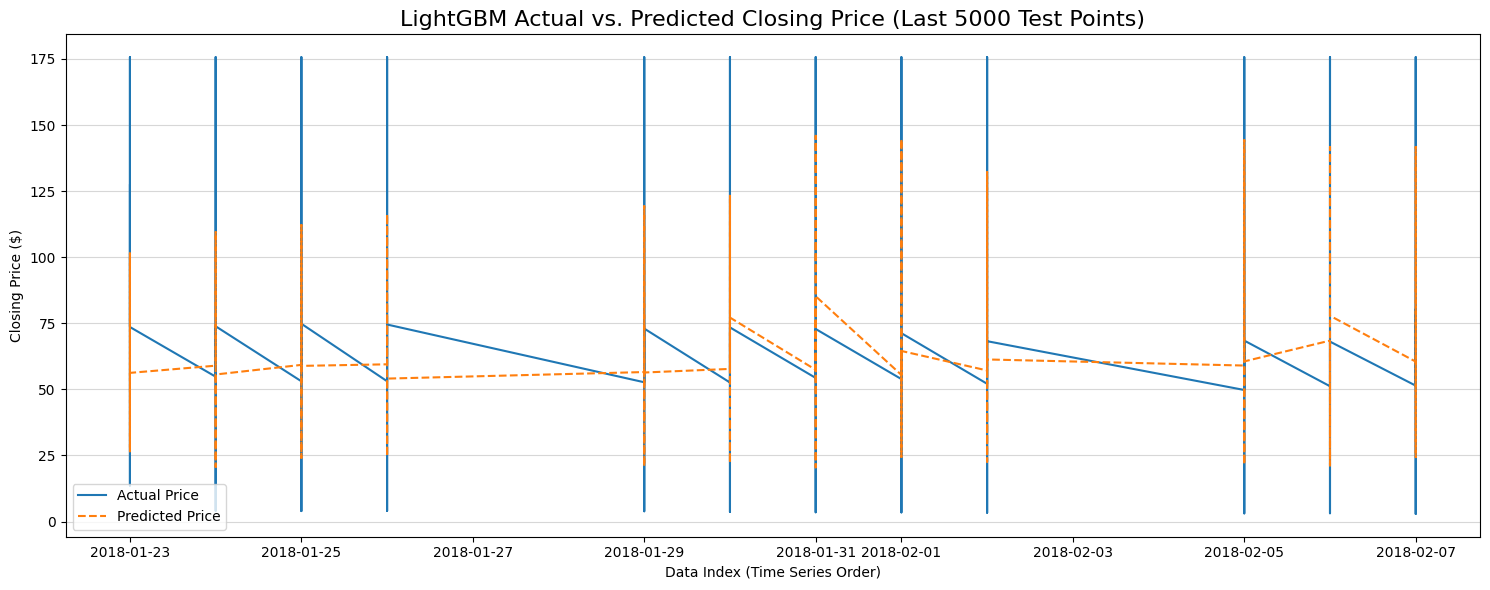

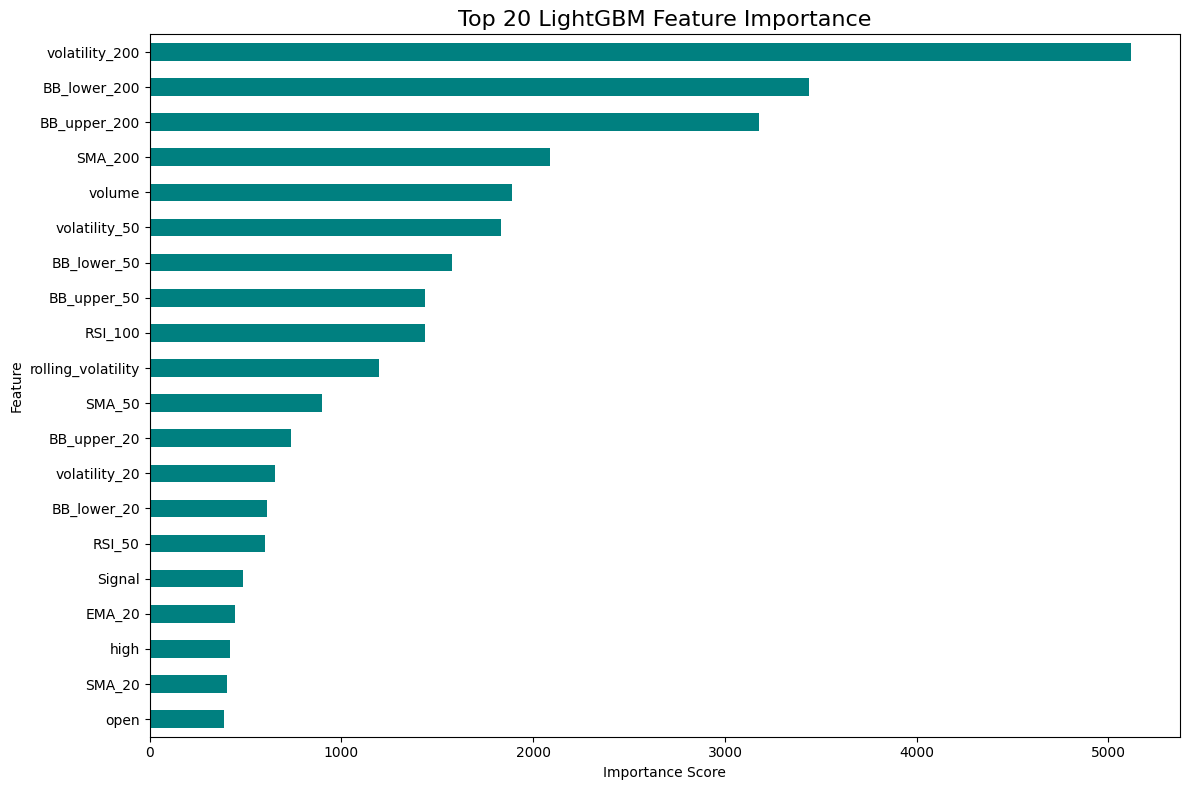

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. PRE-PROCESSING FIX: Ensure a clean, independent DataFrame copy ---
# This step explicitly creates a copy to resolve the SettingWithCopyWarning
# and ensure all subsequent operations modify the correct object.
if isinstance(df_clean, pd.DataFrame):
    df_clean = df_clean.copy()


# --- 2. Target Creation ---
# Create the target variable: the closing price 1 day in the future
df_clean['target'] = df_clean['close'].shift(-1)


# --- 3. CRITICAL FIX: Handle NaNs *Before* Defining X/y or Splitting ---
# We must drop rows where features (SMA, RSI, etc.) or the new target are NaN.
initial_rows = df_clean.shape[0]
df_clean.dropna(inplace=True)
final_rows = df_clean.shape[0]
print(f"Dropped {initial_rows - final_rows} rows containing NaN values.")


# --- 4. Feature and Target Definition (Refined) ---
# Explicitly define columns to exclude to ensure only meaningful features are used.
# Excluded: 'target' (the dependent variable) and any columns that are not features.
EXCLUDED_COLS = [
    'target',       # The variable we are predicting
    # Add any other non-feature columns here if they exist (e.g., specific IDs, date copies)
]

# Select all remaining numeric columns after exclusion
features = [col for col in df_clean.select_dtypes(include=np.number).columns.tolist() if col not in EXCLUDED_COLS]

X = df_clean[features]
y = df_clean['target']


# --- 5. Time-Series Split (70/30 Chronological) ---
split_point = int(len(df_clean) * 0.7)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


# --- 6. Model Training ---
lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'random_state': 42,
    'n_jobs': -1, # Use all available cores
    'verbose': -1 # Suppress logging during training
}

model = lgb.LGBMRegressor(**lgb_params)
print("\nStarting LightGBM training...")
model.fit(X_train, y_train)
print("Training complete.")


# --- 7. Prediction & Evaluation ---
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Model Evaluation (Test Set) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


# --- 8. Plotting Actual vs. Predicted ---
plt.figure(figsize=(15, 6))
# Plot only a segment of the test set for better visual clarity (e.g., last 5000 points)
# Slice the data to get the index for plotting
plot_slice = 5000
start_index = len(y_test) - plot_slice

plt.plot(y_test.index[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
plt.plot(y_test.index[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title(f'LightGBM Actual vs. Predicted Closing Price (Last {plot_slice} Test Points)', fontsize=16)
plt.xlabel('Data Index (Time Series Order)')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 9. Feature Importance (Added for analysis) ---
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.head(20).plot(kind='barh', color='teal')
plt.title('Top 20 LightGBM Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.tight_layout()
plt.show()


Dropped 1 rows containing NaN values.
Training set size: 408527 rows
Testing set size: 175084 rows

Starting LightGBM training...
Training complete.

--- Model Evaluation (Test Set) ---
Root Mean Squared Error (RMSE): 27.5407
Mean Absolute Error (MAE): 18.3391


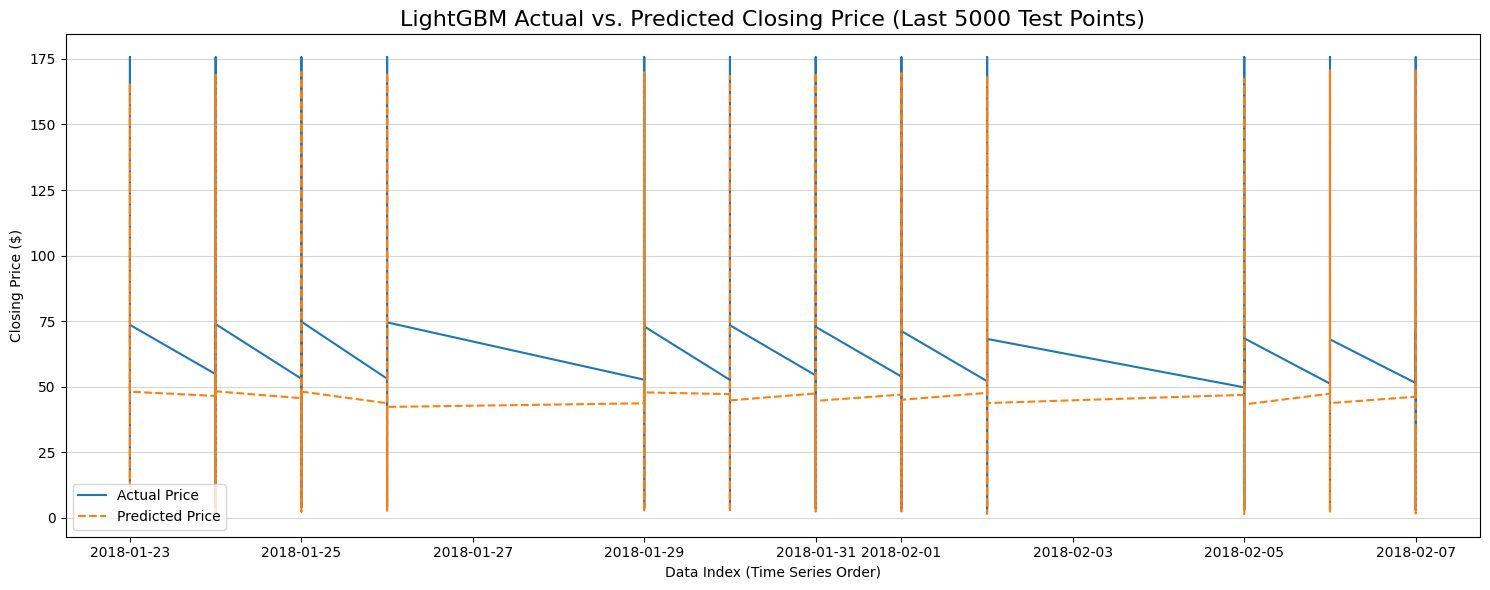

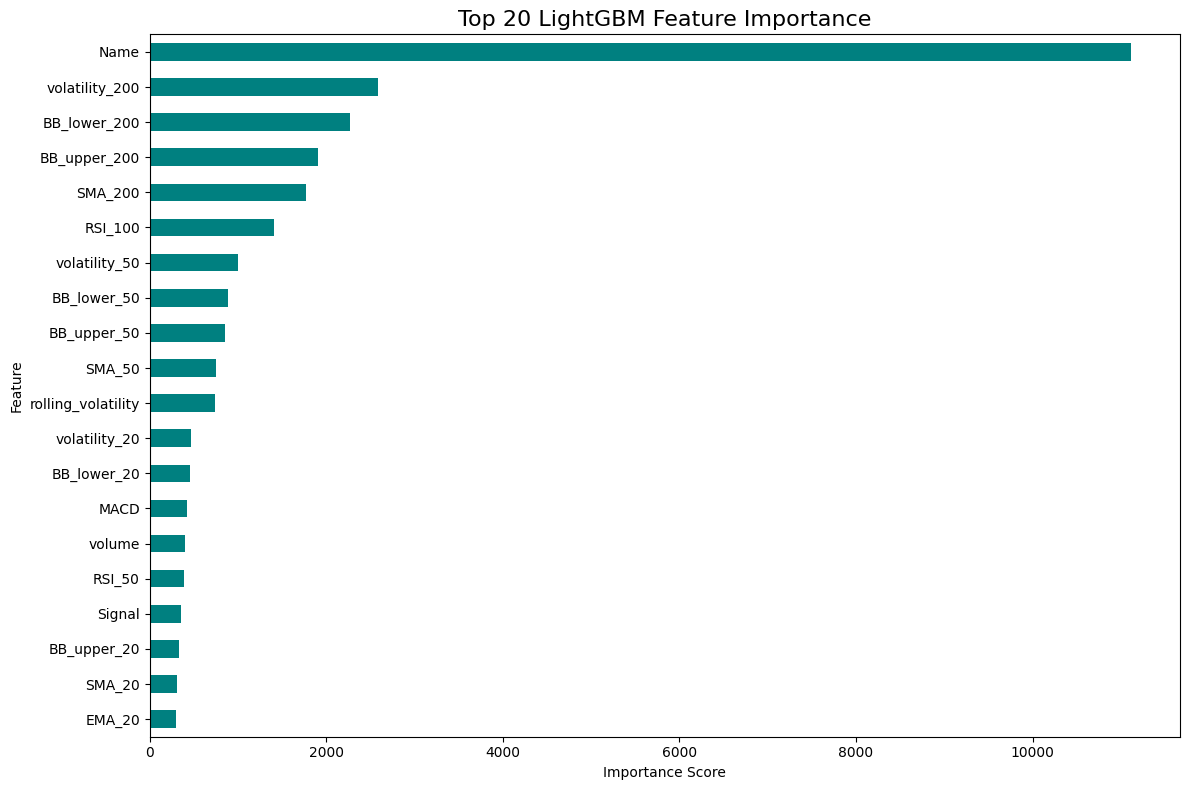

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. PRE-PROCESSING FIX: Ensure a clean, independent DataFrame copy ---
# This step explicitly creates a copy to resolve the SettingWithCopyWarning
# and ensure all subsequent operations modify the correct object.
if isinstance(df_clean, pd.DataFrame):
    df_clean = df_clean.copy()


# --- 2. Target Creation ---
# Create the target variable: the closing price 1 day in the future
df_clean['target'] = df_clean['close'].shift(-1)


# --- 3. CRITICAL FIX: Handle NaNs *Before* Defining X/y or Splitting ---
# We must drop rows where features (SMA, RSI, etc.) or the new target are NaN.
initial_rows = df_clean.shape[0]
df_clean.dropna(inplace=True, subset=['target']) # Drop only based on target for robustness
# Drop NaNs resulting from feature engineering across all remaining columns
df_clean.dropna(inplace=True)
final_rows = df_clean.shape[0]
print(f"Dropped {initial_rows - final_rows} rows containing NaN values.")


# --- 4. Feature Engineering for Model (Crucial Multi-Stock Fix) ---
# Convert the stock name to a categorical type for LightGBM to use it in its decision splits.
df_clean['Name'] = df_clean['Name'].astype('category')


# --- 5. Feature and Target Definition (Refined) ---
# Excluded: 'target' (the dependent variable) and 'date' (already used for time series context).
EXCLUDED_COLS = ['target', 'date']

# Select all columns that are NOT in the excluded list
features = [col for col in df_clean.columns if col not in EXCLUDED_COLS]

X = df_clean[features]
y = df_clean['target']


# --- 6. Time-Series Split (70/30 Chronological) ---
split_point = int(len(df_clean) * 0.7)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


# --- 7. Model Training ---
lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'random_state': 42,
    'n_jobs': -1, # Use all available cores
    'verbose': -1 # Suppress logging during training
}

model = lgb.LGBMRegressor(**lgb_params)
print("\nStarting LightGBM training...")
# Tell the model which features are categorical (just 'Name' in this case)
model.fit(X_train, y_train, categorical_feature=['Name'])
print("Training complete.")


# --- 8. Prediction & Evaluation ---
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Model Evaluation (Test Set) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


# --- 9. Plotting Actual vs. Predicted ---
plt.figure(figsize=(15, 6))
# Plot only a segment of the test set for better visual clarity (e.g., last 5000 points)
# Slice the data to get the index for plotting
plot_slice = 5000
start_index = len(y_test) - plot_slice

plt.plot(y_test.index[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
plt.plot(y_test.index[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title(f'LightGBM Actual vs. Predicted Closing Price (Last {plot_slice} Test Points)', fontsize=16)
plt.xlabel('Data Index (Time Series Order)')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 10. Feature Importance (Added for analysis) ---
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.head(20).plot(kind='barh', color='teal')
plt.title('Top 20 LightGBM Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.tight_layout()
plt.show()


Dropped 1 rows containing NaN values.

Starting 5-Fold Time Series Cross-Validation...
  Fold 1: RMSE = 15.6576, MAE = 8.8965
  Fold 2: RMSE = 20.0296, MAE = 12.7751
  Fold 3: RMSE = 17.5400, MAE = 11.6439
  Fold 4: RMSE = 20.1343, MAE = 12.7723
  Fold 5: RMSE = 26.8812, MAE = 18.1353

--- Cross-Validation Summary ---
Average RMSE across 5 folds: 20.0485
Average MAE across 5 folds: 12.8446

--- Final Model Evaluation (Last Test Fold) ---
Final Test RMSE: 26.8812
Final Test MAE: 18.1353


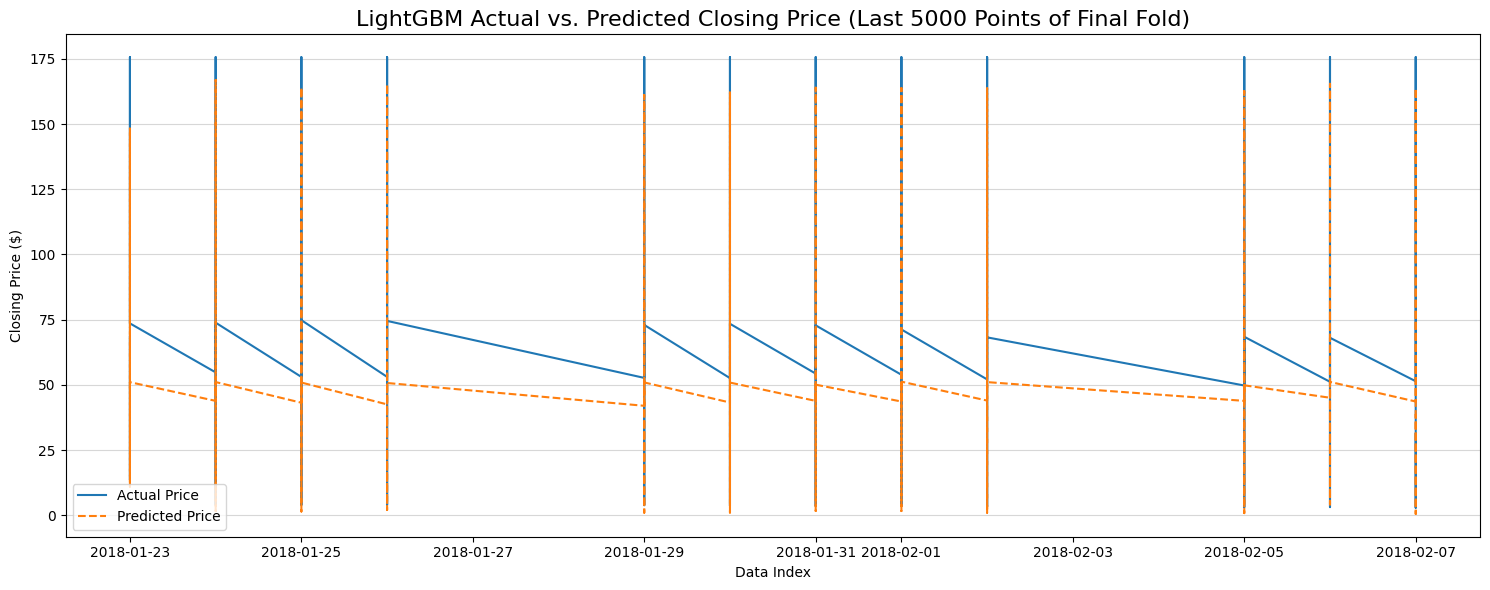

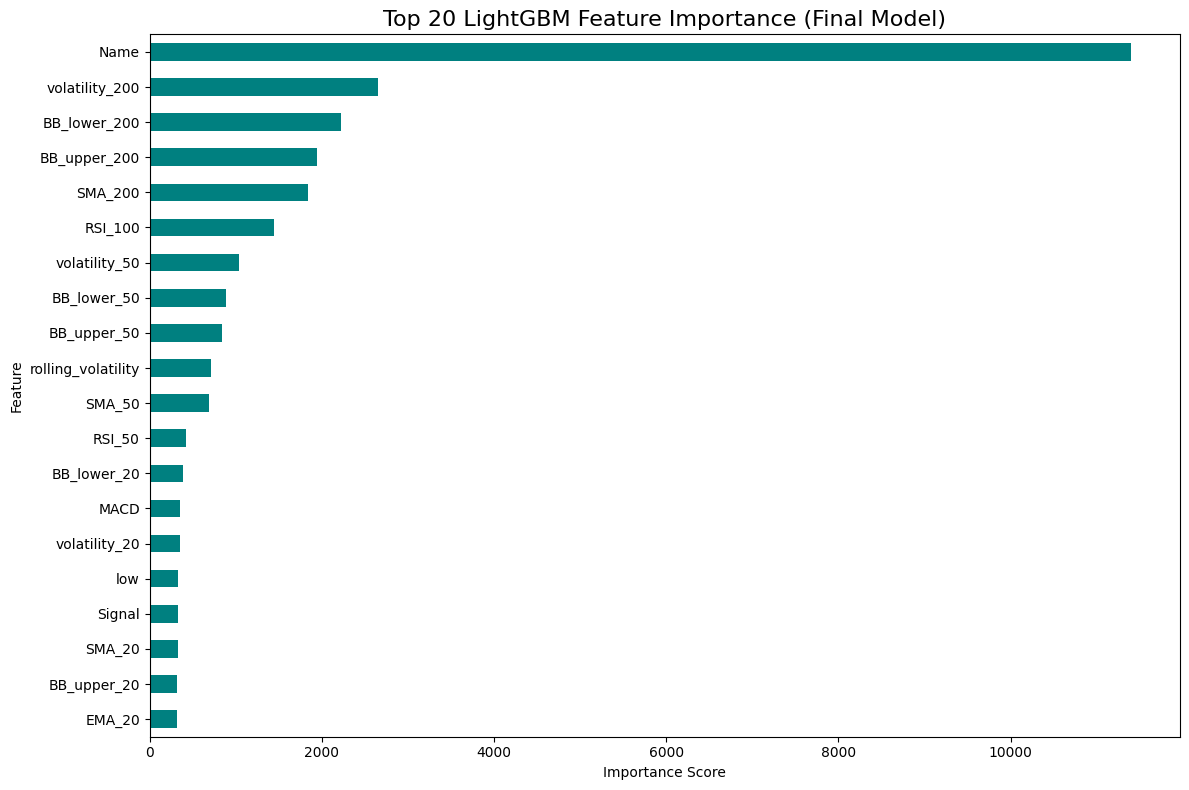

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit # NEW IMPORT for Time Series CV

# --- 1. PRE-PROCESSING FIX: Ensure a clean, independent DataFrame copy ---
# This step explicitly creates a copy to resolve the SettingWithCopyWarning
# and ensure all subsequent operations modify the correct object.
if isinstance(df_clean, pd.DataFrame):
    df_clean = df_clean.copy()


# --- 2. Target Creation ---
# Create the target variable: the closing price 1 day in the future
df_clean['target'] = df_clean['close'].shift(-1)


# --- 3. CRITICAL FIX: Handle NaNs *Before* Defining X/y or Splitting ---
# We must drop rows where features (SMA, RSI, etc.) or the new target are NaN.
initial_rows = df_clean.shape[0]
df_clean.dropna(inplace=True, subset=['target']) # Drop only based on target for robustness
# Drop NaNs resulting from feature engineering across all remaining columns
df_clean.dropna(inplace=True)
final_rows = df_clean.shape[0]
print(f"Dropped {initial_rows - final_rows} rows containing NaN values.")


# --- 4. Feature Engineering for Model (Crucial Multi-Stock Fix) ---
# Convert the stock name to a categorical type for LightGBM to use it in its decision splits.
df_clean['Name'] = df_clean['Name'].astype('category')


# --- 5. Feature and Target Definition (Refined) ---
# Excluded: 'target' (the dependent variable) and 'date' (already used for time series context).
EXCLUDED_COLS = ['target', 'date']

# Select all columns that are NOT in the excluded list
features = [col for col in df_clean.columns if col not in EXCLUDED_COLS]

X = df_clean[features]
y = df_clean['target']


# --- 6. Time-Series Cross-Validation (TSCv) ---
# Use TimeSeriesSplit for robust evaluation across 5 distinct chronological folds
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store metrics from each fold
fold_rmses = []
fold_maes = []
test_split_indices = []

print(f"\nStarting {n_splits}-Fold Time Series Cross-Validation...")

lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# --- 7. Iterative Model Training and Evaluation using CV ---
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model_fold = lgb.LGBMRegressor(**lgb_params)
    model_fold.fit(X_train_fold, y_train_fold, categorical_feature=['Name'])

    y_pred_fold = model_fold.predict(X_test_fold)

    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    fold_rmses.append(rmse_fold)
    fold_maes.append(mae_fold)
    test_split_indices.append(test_index)

    print(f"  Fold {fold + 1}: RMSE = {rmse_fold:.4f}, MAE = {mae_fold:.4f}")


# --- 8. Final CV Metrics and Full Training Set Definition ---
avg_rmse = np.mean(fold_rmses)
avg_mae = np.mean(fold_maes)

print("\n--- Cross-Validation Summary ---")
print(f"Average RMSE across {n_splits} folds: {avg_rmse:.4f}")
print(f"Average MAE across {n_splits} folds: {avg_mae:.4f}")

# Define the final full training and testing sets based on the last CV split
# This ensures we plot the results of the largest training set possible,
# which corresponds to the last fold's train/test split.
final_train_index, final_test_index = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[final_train_index], X.iloc[final_test_index]
y_train, y_test = y.iloc[final_train_index], y.iloc[final_test_index]

# Re-train the model on the largest possible training set for final prediction/plotting
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=['Name'])


# --- 9. Prediction & Evaluation on FINAL Test Set (Largest) ---
y_pred = model.predict(X_test)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
mae_final = mean_absolute_error(y_test, y_pred)

print("\n--- Final Model Evaluation (Last Test Fold) ---")
print(f"Final Test RMSE: {rmse_final:.4f}")
print(f"Final Test MAE: {mae_final:.4f}")


# --- 10. Plotting Actual vs. Predicted (Only the Final Test Fold) ---
plt.figure(figsize=(15, 6))
# Plot only a segment of the final test set for better visual clarity (e.g., last 5000 points)
plot_slice = 5000
start_index = len(y_test) - plot_slice

# Ensure that we are plotting the actual dates if the index is the date column
if 'date' in df_clean.columns:
    date_index = df_clean.iloc[final_test_index]['date']
    plt.plot(date_index.iloc[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
    plt.plot(date_index.iloc[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)
else:
    plt.plot(y_test.index[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
    plt.plot(y_test.index[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title(f'LightGBM Actual vs. Predicted Closing Price (Last {plot_slice} Points of Final Fold)', fontsize=16)
plt.xlabel('Date' if 'date' in df_clean.columns else 'Data Index')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 11. Feature Importance (From the final model trained on largest set) ---
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.head(20).plot(kind='barh', color='teal')
plt.title('Top 20 LightGBM Feature Importance (Final Model)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.tight_layout()
plt.show()


/tmp/ipython-input-850717898.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['close_lag1'] = df_clean.groupby('Name')['close'].shift(1)
/tmp/ipython-input-850717898.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['volume_lag1'] = df_clean.groupby('Name')['volume'].shift(1)
/tmp/ipython-input-850717898.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['return_lag1'] = df_clean.group

Dropped 504 rows containing NaN values.

Starting Hyperparameter Tuning with Randomized Search (3-Fold CV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

--- Best Hyperparameters Found ---
{'num_leaves': 31, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.05}

Starting Final 5-Fold Time Series Cross-Validation...
  Fold 1: RMSE = 15.7790, MAE = 8.9227
  Fold 2: RMSE = 20.0160, MAE = 12.8350
  Fold 3: RMSE = 17.6890, MAE = 11.6954
  Fold 4: RMSE = 19.9797, MAE = 12.6414
  Fold 5: RMSE = 26.4538, MAE = 17.7636

--- Cross-Validation Summary (using Optimized Parameters) ---
Average RMSE across 5 folds: 19.9835
Average MAE across 5 folds: 12.7716

--- Final Model Evaluation (Last Test Fold) ---
Final Test RMSE: 26.4538
Final Test MAE: 17.7636


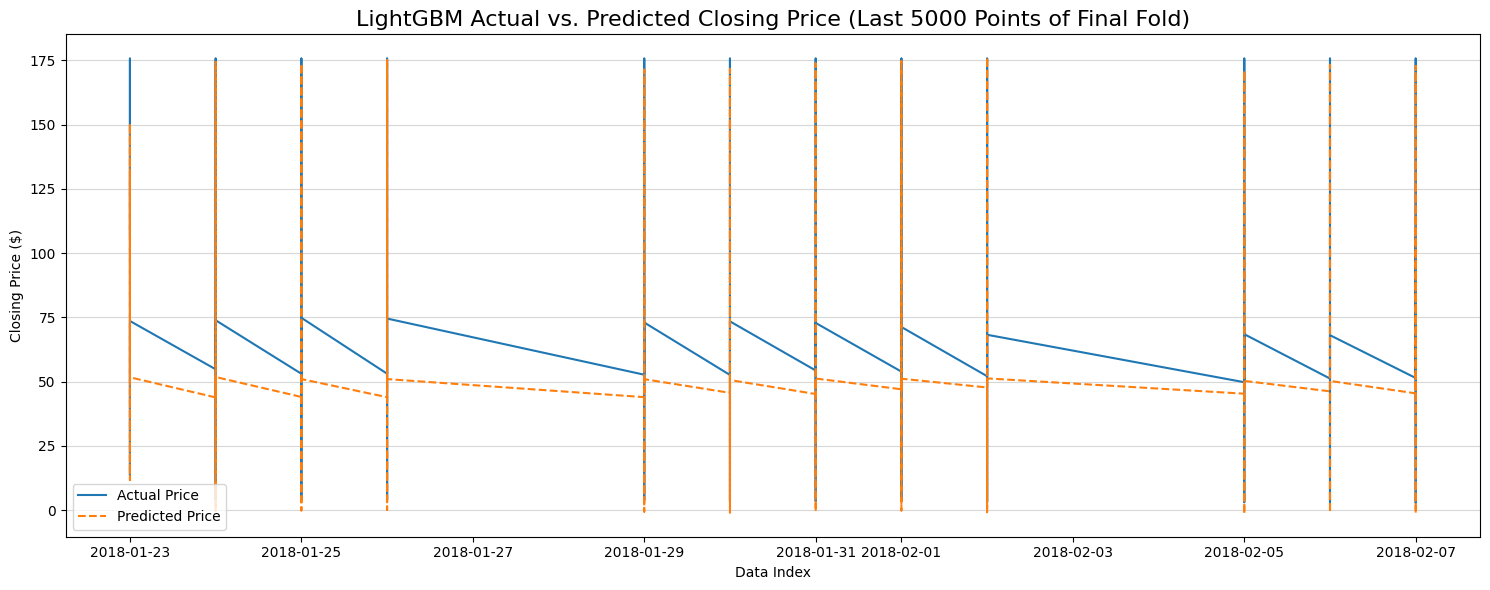

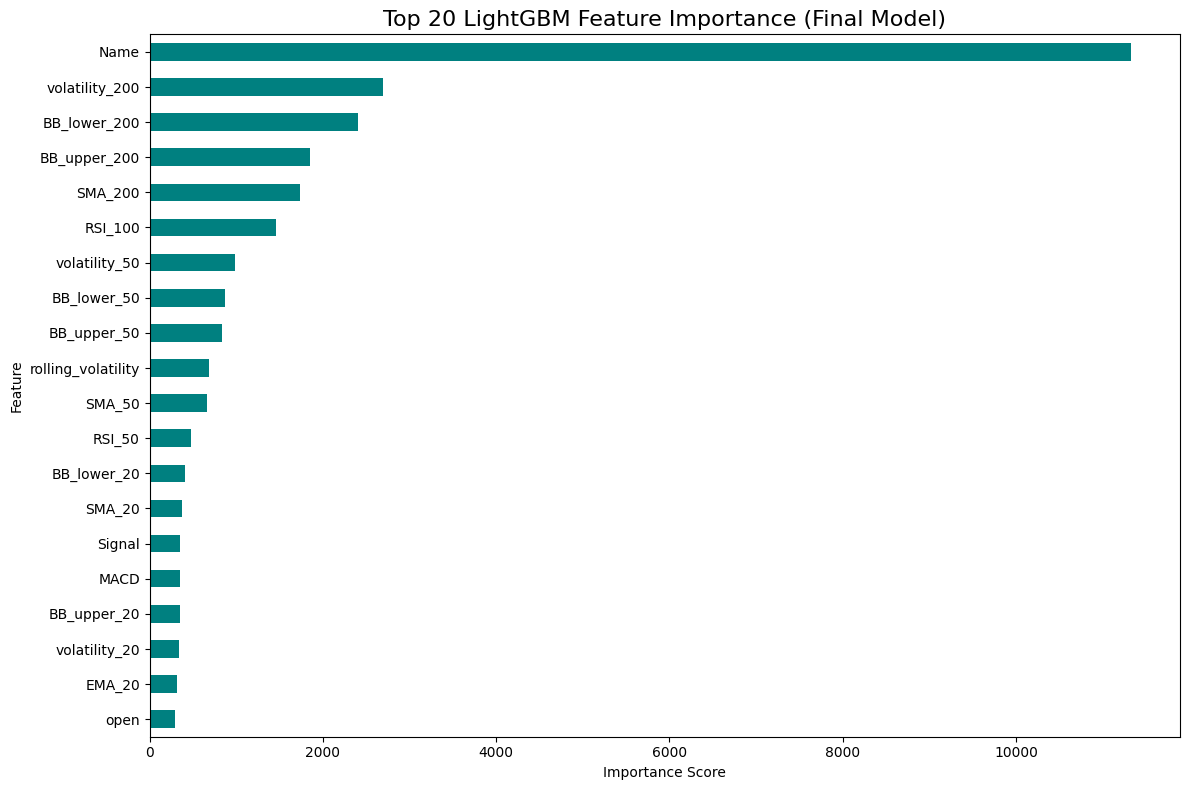

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# --- 1. PRE-PROCESSING FIX: Ensure a clean, independent DataFrame copy ---
if isinstance(df_clean, pd.DataFrame):
    df_clean = df_clean.copy()


# --- 2. Target Creation and Advanced Feature Engineering ---
# Create the target variable: the closing price 1 day in the future
df_clean['target'] = df_clean['close'].shift(-1)

# Add lagged features for momentum (t-1)
# These features tell the model what the stock was doing yesterday, which is highly predictive.
df_clean['close_lag1'] = df_clean.groupby('Name')['close'].shift(1)
df_clean['volume_lag1'] = df_clean.groupby('Name')['volume'].shift(1)
df_clean['return_lag1'] = df_clean.groupby('Name')['daily_return'].shift(1)

# --- 3. CRITICAL FIX: Handle NaNs *Before* Defining X/y or Splitting ---
# We must drop rows where features (SMA, RSI, etc.) or the new target are NaN.
initial_rows = df_clean.shape[0]
df_clean.dropna(inplace=True, subset=['target'])
df_clean.dropna(inplace=True) # Drop NaNs resulting from feature engineering across all remaining columns
final_rows = df_clean.shape[0]
print(f"Dropped {initial_rows - final_rows} rows containing NaN values.")


# --- 4. Feature Engineering for Model (Crucial Multi-Stock Fix) ---
# Convert the stock name to a categorical type for LightGBM.
df_clean['Name'] = df_clean['Name'].astype('category')


# --- 5. Feature and Target Definition (Refined) ---
EXCLUDED_COLS = ['target', 'date']

# Separate numeric and categorical features
numeric_features = [col for col in df_clean.select_dtypes(include=np.number).columns if col not in EXCLUDED_COLS]
categorical_features = ['Name']

# Final feature list
features = numeric_features + categorical_features

X = df_clean[features]
y = df_clean['target']


# --- 6. Time-Series Cross-Validation (TSCv) for Hyperparameter Tuning (REDUCED FOR SPEED) ---
# Use TimeSeriesSplit for chronological splitting
n_splits = 3
tscv_tuning = TimeSeriesSplit(n_splits=n_splits)

# Define the model and parameter grid for tuning
# n_estimators REDUCED to 200 for faster tuning
lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, n_estimators=200)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [10, 20, 30]
}

print("\nStarting Hyperparameter Tuning with Randomized Search (3-Fold CV)...")
# n_iter REDUCED to 5 for faster execution (15 models instead of 30)
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Reduced from 10 to 5 for speed
    scoring='neg_mean_absolute_error',
    cv=tscv_tuning,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Scale only the numeric features (StandardScaler)
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_features])
X_scaled = X.copy()
X_scaled[numeric_features] = X_numeric_scaled

# Perform tuning on the scaled data
# This step is the slowest, but we have optimized its parameters (n_iter, n_estimators)
random_search.fit(X_scaled, y, categorical_feature=categorical_features)

best_params = random_search.best_params_
print("\n--- Best Hyperparameters Found ---")
print(best_params)

# Update parameters for final model training (Use 1000 estimators for final training)
lgb_params = {**lgb.LGBMRegressor().get_params(), **best_params, 'n_estimators': 1000, 'random_state': 42, 'n_jobs': -1, 'verbose': -1}


# --- 7. Final Model Evaluation using 5-Fold TSCv ---
n_splits_final = 5
tscv_final = TimeSeriesSplit(n_splits=n_splits_final)
fold_rmses = []
fold_maes = []
test_split_indices = []

print(f"\nStarting Final {n_splits_final}-Fold Time Series Cross-Validation...")

# Iterative Model Training and Evaluation using CV
for fold, (train_index, test_index) in enumerate(tscv_final.split(X)):
    X_train_fold, X_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model_fold = lgb.LGBMRegressor(**lgb_params)
    # Use the optimized parameters found in the tuning step
    model_fold.fit(X_train_fold, y_train_fold, categorical_feature=categorical_features)

    y_pred_fold = model_fold.predict(X_test_fold)

    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    fold_rmses.append(rmse_fold)
    fold_maes.append(mae_fold)
    test_split_indices.append(test_index)

    print(f"  Fold {fold + 1}: RMSE = {rmse_fold:.4f}, MAE = {mae_fold:.4f}")


# --- 8. Final CV Metrics and Full Training Set Definition ---
avg_rmse = np.mean(fold_rmses)
avg_mae = np.mean(fold_maes)

print("\n--- Cross-Validation Summary (using Optimized Parameters) ---")
print(f"Average RMSE across {n_splits_final} folds: {avg_rmse:.4f}")
print(f"Average MAE across {n_splits_final} folds: {avg_mae:.4f}")

# Define the final full training and testing sets based on the last CV split
final_train_index, final_test_index = list(tscv_final.split(X))[-1]
X_train, X_test = X_scaled.iloc[final_train_index], X_scaled.iloc[final_test_index]
y_train, y_test = y.iloc[final_train_index], y.iloc[final_test_index]


# Re-train the model on the largest possible training set for final prediction/plotting
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=categorical_features)


# --- 9. Prediction & Evaluation on FINAL Test Set (Largest) ---
y_pred = model.predict(X_test)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
mae_final = mean_absolute_error(y_test, y_pred)

print("\n--- Final Model Evaluation (Last Test Fold) ---")
print(f"Final Test RMSE: {rmse_final:.4f}")
print(f"Final Test MAE: {mae_final:.4f}")


# --- 10. Plotting Actual vs. Predicted (Only the Final Test Fold) ---
plt.figure(figsize=(15, 6))
# Plot only a segment of the final test set for better visual clarity (e.g., last 5000 points)
plot_slice = 5000
start_index = len(y_test) - plot_slice

# Ensure that we are plotting the actual dates if the index is the date column
if 'date' in df_clean.columns:
    date_index = df_clean.iloc[final_test_index]['date']
    plt.plot(date_index.iloc[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
    plt.plot(date_index.iloc[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)
else:
    plt.plot(y_test.index[start_index:], y_test.values[start_index:], label='Actual Price', color='#1f77b4', linewidth=1.5)
    plt.plot(y_test.index[start_index:], y_pred[start_index:], label='Predicted Price', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title(f'LightGBM Actual vs. Predicted Closing Price (Last {plot_slice} Points of Final Fold)', fontsize=16)
plt.xlabel('Date' if 'date' in df_clean.columns else 'Data Index')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 11. Feature Importance (From the final model trained on largest set) ---
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.head(20).plot(kind='barh', color='teal')
plt.title('Top 20 LightGBM Feature Importance (Final Model)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.tight_layout()
plt.show()

/tmp/ipython-input-134501105.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['close_lag1'] = df_clean.groupby('Name')['close'].shift(1)
/tmp/ipython-input-134501105.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['volume_lag1'] = df_clean.groupby('Name')['volume'].shift(1)
/tmp/ipython-input-134501105.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean['return_lag1'] = df_clean.group

Dropped 504 rows containing NaN values.

Starting Hyperparameter Tuning with Randomized Search (3-Fold CV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

--- Best Hyperparameters Found ---
{'num_leaves': 31, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.01}

Starting Final 5-Fold Time Series Cross-Validation...
  Fold 1: RMSE = 0.013264, MAE = 0.008855
  Fold 2: RMSE = 0.014944, MAE = 0.009928
  Fold 3: RMSE = 0.019099, MAE = 0.012528
  Fold 4: RMSE = 0.015288, MAE = 0.009890
  Fold 5: RMSE = 0.014773, MAE = 0.009455

--- Cross-Validation Summary (Predicting Daily Returns) ---
Average RMSE across 5 folds: 0.015474
Average MAE across 5 folds: 0.010131

--- Final Model Evaluation (Last Test Fold) ---
Final Test RMSE: 0.014773
Final Test MAE: 0.009455


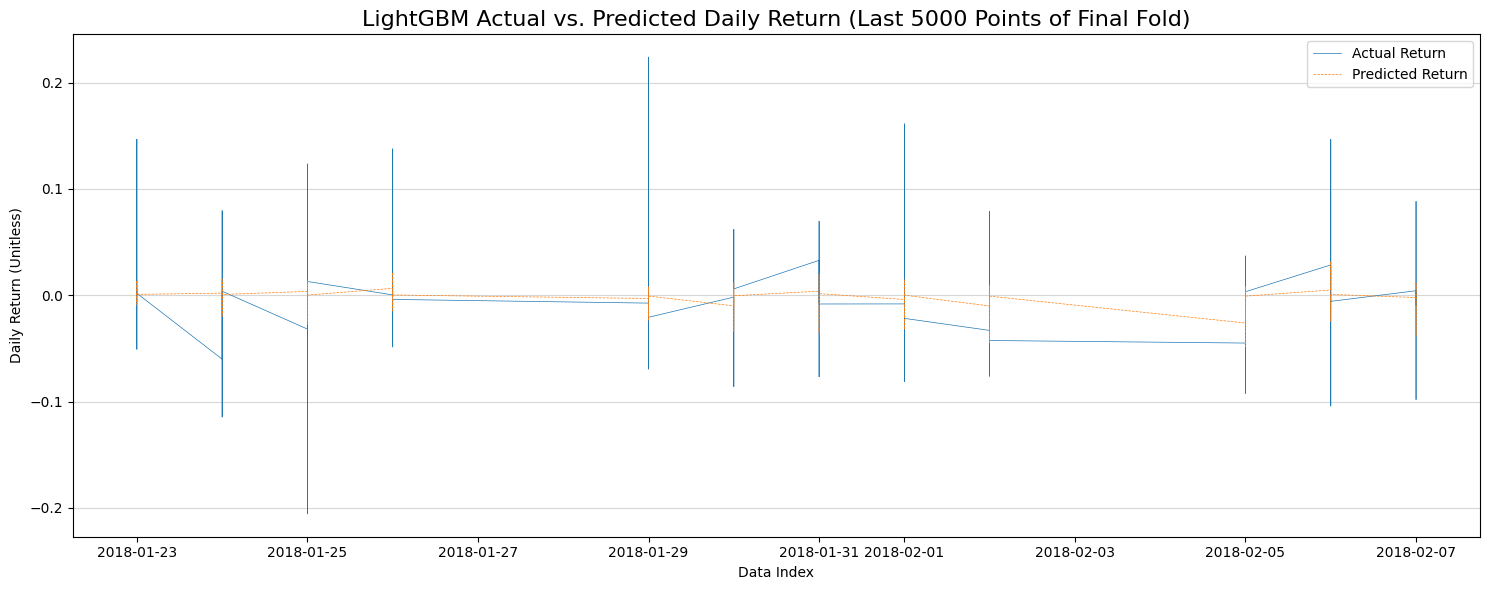

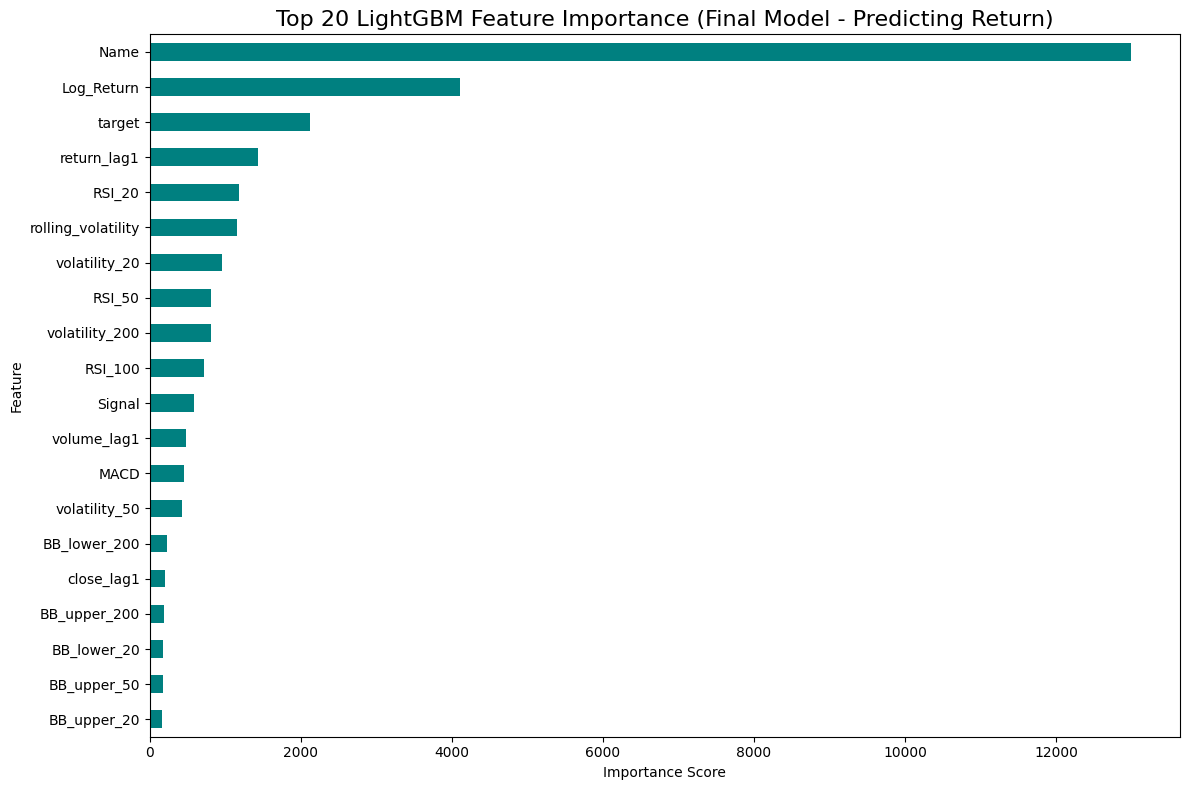

In [ ]:
  import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# --- 1. PRE-PROCESSING FIX: Ensure a clean, independent DataFrame copy ---
if isinstance(df_clean, pd.DataFrame):
    df_clean = df_clean.copy()


# --- 2. Target Creation (CRITICAL CHANGE: Predicting Daily Return) ---
# New Target: The next day's daily return (R_t+1)
df_clean['target_return'] = df_clean['daily_return'].shift(-1)

# Add lagged features for momentum (t-1)
# Keep lagged features as dollar values, but the target is now return
df_clean['close_lag1'] = df_clean.groupby('Name')['close'].shift(1)
df_clean['volume_lag1'] = df_clean.groupby('Name')['volume'].shift(1)
df_clean['return_lag1'] = df_clean.groupby('Name')['daily_return'].shift(1)


# --- 3. CRITICAL FIX: Handle NaNs *Before* Defining X/y or Splitting ---
initial_rows = df_clean.shape[0]
df_clean.dropna(inplace=True, subset=['target_return']) # Drop only based on new target
df_clean.dropna(inplace=True) # Drop NaNs resulting from feature engineering across all remaining columns
final_rows = df_clean.shape[0]
print(f"Dropped {initial_rows - final_rows} rows containing NaN values.")


# --- 4. Feature Engineering for Model (Crucial Multi-Stock Fix) ---
df_clean['Name'] = df_clean['Name'].astype('category')


# --- 5. Feature and Target Definition (Predicting Return) ---
# IMPORTANT CHANGE: The target is now 'target_return'
EXCLUDED_COLS = ['target_return', 'date', 'open', 'high', 'low', 'close', 'volume', 'daily_return'] # Keep excluding current price/volume features

# Separate numeric and categorical features
numeric_features = [col for col in df_clean.select_dtypes(include=np.number).columns if col not in EXCLUDED_COLS]
categorical_features = ['Name']

# Final feature list
features = numeric_features + categorical_features

X = df_clean[features]
y = df_clean['target_return'] # <--- Target is now Daily Return


# --- 6. Time-Series Cross-Validation (TSCv) for Hyperparameter Tuning (REDUCED FOR SPEED) ---
n_splits = 3
tscv_tuning = TimeSeriesSplit(n_splits=n_splits)

lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, n_estimators=200)
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05], # Fine-tuning learning rate for return data
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10],
    'min_child_samples': [10, 20]
}

print("\nStarting Hyperparameter Tuning with Randomized Search (3-Fold CV)...")

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_features])
X_scaled = X.copy()
X_scaled[numeric_features] = X_numeric_scaled

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Reduced from 10 to 5 for speed
    scoring='neg_mean_absolute_error',
    cv=tscv_tuning,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_scaled, y, categorical_feature=categorical_features)

best_params = random_search.best_params_
print("\n--- Best Hyperparameters Found ---")
print(best_params)

lgb_params = {**lgb.LGBMRegressor().get_params(), **best_params, 'n_estimators': 1000, 'random_state': 42, 'n_jobs': -1, 'verbose': -1}


# --- 7. Final Model Evaluation using 5-Fold TSCv ---
n_splits_final = 5
tscv_final = TimeSeriesSplit(n_splits=n_splits_final)
fold_rmses = []
fold_maes = []

print(f"\nStarting Final {n_splits_final}-Fold Time Series Cross-Validation...")

# Iterative Model Training and Evaluation using CV
for fold, (train_index, test_index) in enumerate(tscv_final.split(X)):
    X_train_fold, X_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model_fold = lgb.LGBMRegressor(**lgb_params)
    model_fold.fit(X_train_fold, y_train_fold, categorical_feature=categorical_features)

    y_pred_fold = model_fold.predict(X_test_fold)

    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    fold_rmses.append(rmse_fold)
    fold_maes.append(mae_fold)

    print(f"  Fold {fold + 1}: RMSE = {rmse_fold:.6f}, MAE = {mae_fold:.6f}") # Print 6 decimals for returns


# --- 8. Final CV Metrics and Full Training Set Definition ---
avg_rmse = np.mean(fold_rmses)
avg_mae = np.mean(fold_maes)

print("\n--- Cross-Validation Summary (Predicting Daily Returns) ---")
print(f"Average RMSE across {n_splits_final} folds: {avg_rmse:.6f}")
print(f"Average MAE across {n_splits_final} folds: {avg_mae:.6f}") # This value is the average error in percentage points

# Define the final full training and testing sets based on the last CV split
final_train_index, final_test_index = list(tscv_final.split(X))[-1]
X_train, X_test = X_scaled.iloc[final_train_index], X_scaled.iloc[final_test_index]
y_train, y_test = y.iloc[final_train_index], y.iloc[final_test_index]


# Re-train the model on the largest possible training set for final prediction/plotting
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=categorical_features)


# --- 9. Prediction & Evaluation on FINAL Test Set (Largest) ---
y_pred = model.predict(X_test)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
mae_final = mean_absolute_error(y_test, y_pred)

print("\n--- Final Model Evaluation (Last Test Fold) ---")
print(f"Final Test RMSE: {rmse_final:.6f}")
print(f"Final Test MAE: {mae_final:.6f}")


# --- 10. Plotting (Now plotting predicted vs actual RETURN) ---
plt.figure(figsize=(15, 6))
plot_slice = 5000
start_index = len(y_test) - plot_slice

# Plotting the actual vs predicted returns
if 'date' in df_clean.columns:
    date_index = df_clean.iloc[final_test_index]['date']
    plt.plot(date_index.iloc[start_index:], y_test.values[start_index:], label='Actual Return', color='#1f77b4', linewidth=0.5)
    plt.plot(date_index.iloc[start_index:], y_pred[start_index:], label='Predicted Return', color='#ff7f0e', linestyle='--', linewidth=0.5)
else:
    plt.plot(y_test.index[start_index:], y_test.values[start_index:], label='Actual Return', color='#1f77b4', linewidth=0.5)
    plt.plot(y_test.index[start_index:], y_pred[start_index:], label='Predicted Return', color='#ff7f0e', linestyle='--', linewidth=0.5)

plt.title(f'LightGBM Actual vs. Predicted Daily Return (Last {plot_slice} Points of Final Fold)', fontsize=16)
plt.xlabel('Date' if 'date' in df_clean.columns else 'Data Index')
plt.ylabel('Daily Return (Unitless)')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 11. Feature Importance (From the final model trained on largest set) ---
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importance.head(20).plot(kind='barh', color='teal')
plt.title('Top 20 LightGBM Feature Importance (Final Model - Predicting Return)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.tight_layout()
plt.show()
